# **Project Title: Lyrics Generation using Language Models**

**Team Name:** <br> Blink-128 <br><br>
**Team Members:** <br>
- Mansi Palekar
- Chaitanya GVS

## **Introduction**

Creativity might be the ultimate measure of Artificial Intelligence and once such creative field is Song Writing. For this project, our objective is to explore the capability of Language Models to generate lyrics
for songs. <br>
In pursuit of this, we have collected lyrical data for 3 genres and 5 artists belonging to each of the chosen genres. For each of these genres, we've built 3 language models and then picked the best for further fine-tuning on artist datasets. These fine-tuned models are then being used for lyrical generation. <br>

**Chosen Genres**: Pop, Rock and Rap. <br>
**The Language Models used:** Baseline Vanilla LSTM, Transformer Models RoBERTa and GPT2 from the 🤗 library.

<br>

**Flow of the project:**

- Data Collection: Scrape and collect the lyrics of Billboard Hot-100 songs from $1960-2021$ and select the songs belonging to Pop, Rock and Rap. Similarly, scrape and collect lyrics of songs of 5 artists from those 3 selected genres.

- Exploratory Data Analysis: We explore most frequent words, average line length, vocabulary richness, etc for each of the 3 selected genres.

- Data Pre-processing: We process the lyrical data as required for each of the 3 language models.

- Modeling: Created different language models using Vanilla LSTMs and 🤗 Transformers (RoBERTa and GPT). Next, we trained the language models using the lyrics for the 3 genres separately.

- Fine-Tuning: Select the best model for each of the genres based on the performance metrics and fine-tune the models using the lyrics of the selected artists. We will finally have 15 models (3 genres x 5 artists) using which we will generate lyrics.

<br>

**Dataset(s):** 

[Link](https://drive.google.com/drive/folders/1axOWgDeQ2C8-u0caDwA6rtkd0Fy9uEoh?usp=sharing) for the folder of datasets.

This folder consists lyrics of all the songs in Billboard Hot 100 from $1960-2021$ which are from the Pop, Rock & Rap genres. It contains sub-folders containing song lyrics of the selected 15 artists (5 for Pop, Rock & Rap each).

<br>

**Unique Selling Point:**

It would be amazing if we could play around and experiment with different combinations of genre and artist models to reimagine what an artist would be like if they belonged to a different genre, or mashed up their lyrical style with someone else.

**References:** <br>
1. [Deep Learning in Musical Lyric Generation: An LSTM-Based Approach (Gill et al., 2020)](https://elischolar.library.yale.edu/yurj/vol1/iss1/1/)
2. [GhostWriter: Using an LSTM for Automatic Rap Lyric Generation (Potash et al., 2015)](https://aclanthology.org/D15-1221.pdf)
3. [A melody-conditioned lyrics language model (Watanabe et al., 2018)](https://aclanthology.org/N18-1015.pdf)


# **Setup Notebook**

**Mounting the Google Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Installing Transformers and Datasets from 🤗**

In [ ]:
! pip install transformers

In [ ]:
! pip install datasets

**Imports**

In [ ]:
import re
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import MinMaxScaler, MultiLabelBinarizer

import requests
import wikipedia # Package to acces the Wikipedia API
import spotipy # Package to acces the Spotify API
from spotipy.oauth2 import SpotifyClientCredentials # Module to authenticate a Spotify User

from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys

import tensorflow as tf
from tensorflow import keras
from datasets import load_dataset
from tensorflow.python.keras import backend as K
from transformers import AutoTokenizer, TFAutoModelForMaskedLM, TFAutoModelForCausalLM, DataCollatorForLanguageModeling, pipeline

import time
from time import sleep
from tqdm import tqdm
from ast import literal_eval
from copy import deepcopy
from fuzzywuzzy import fuzz 
from collections import Counter,OrderedDict
from pathlib import Path

from wordcloud import WordCloud, STOPWORDS
import matplotlib.patheffects as path_effects
from matplotlib.colors import LinearSegmentedColormap
from plottable import ColumnDefinition,Table
from plottable.cmap import normed_cmap

from IPython.display import clear_output
import warnings
warnings.filterwarnings("ignore")

c:\Users\Chaitanya\anaconda3\lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


**Verify Setup**

In [ ]:
print("transformers version", transformers.__version__)
print("tensorflow version", tf.__version__)

devices = tf.config.experimental.get_visible_devices()
print("Devices:", devices)
print(tf.config.experimental.list_logical_devices('GPU'))

print("GPU Available: ", tf.config.list_physical_devices('GPU'))
print("All Physical Devices", tf.config.list_physical_devices())

transformers version 4.25.1
tensorflow version 2.9.2
Devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[LogicalDevice(name='/device:GPU:0', device_type='GPU')]
GPU Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
All Physical Devices [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# **Data Collection and Cleaning**

Initialising spotipy object to call the Spotify API functions using the `client_id` and `client_secret`

In [ ]:
clientID = '60f1e0a91b764b9eac6b5d652f8bb384'
clientSecret = '5f34cf94b74c43ec853706b274e7675b'

In [ ]:
client_credentials_manager = SpotifyClientCredentials(client_id=clientID, client_secret=clientSecret)
sp = spotipy.Spotify(client_credentials_manager = client_credentials_manager)

## **Data Collection - Billboard Hot-100 Year-End Charts**

__Function to scrape the Billboard chart of an year available in Wikipedia__

In [ ]:
def getBillboard(year):
    
    mainURL = 'https://en.wikipedia.org/wiki/Billboard_Year-End_Hot_100_singles_of_' # Root URL path
    req = requests.get(mainURL+str(year)) # Getting the response object from the URL
    text = req.text # Getting the text in the response object

    soup = BeautifulSoup(markup=text,features = 'html.parser')   # Initialising a Beautiful Soup object to parse the HTML text

    # Creating empty lists to store the Rank, Song Name and Artist Name in the Billboard chart
    rank = []
    song = []
    artist = []
    # Parsing through the text and storing the required information
    for row in soup.find_all('table',attrs={'class':'wikitable'})[0].find_all('tr'):
        if row.find('th'):
            continue
        if row.find('td'):
            rank.append(row.contents[1].text)
            song.append(row.contents[3].text)
            artist.append(row.contents[5].text)        

    # Converting the stored information into a DataFrame
    df = pd.DataFrame()
    df['Rank'] = rank
    df['Song'] = song
    df['Artist'] = artist
    df['Year'] = year
    
    return df

Iterating from the year 1960-2021 and appending the Billboard DataFrame of each year


In [ ]:
dfBillboards = pd.DataFrame()
for year in tqdm(range(1960,2022)):
    dfBillboards = dfBillboards.append(getBillboard(year))

Formatting the text in the dataframe by removing the unneccessary characters  

In [ ]:
dfBillboards['Rank'] = dfBillboards['Rank'].str.replace('\n','')
dfBillboards['Artist'] = dfBillboards['Artist'].str.replace('\n','')
dfBillboards['Song'] = dfBillboards['Song'].str.replace('"','')

In [ ]:
dfBillboards.reset_index(inplace=True,drop=True)

Storing the Billboards dataframe

In [ ]:
dfBillboards.to_csv(r'Data\Billboards.csv',index=False)

Reading the Billboards dataframe

In [ ]:
dfBillboards = pd.read_csv(r'Data\Billboards.csv')

## **Data Collection - Spotify Details of the Billboard Hits**

__Creating a loop to iterate over each song in the Billboard DataFrame and to store the Spotify URI (Unique Reference Identifier) of that song.__

In [ ]:
songURIList = [] # List to store the URIs 
for idx,_ in tqdm(dfBillboards.iterrows()): # Iterating through each song in the dataframe
    
    # Storing the song name and song release year
    track = dfBillboards['Song'][idx] 
    year = dfBillboards['Year'][idx]

    # Using Spotify API's search function to search for the track with multiple try and except blocks for error handling  
    try:
        artist = dfBillboards['Artist'][idx]
        searchResults = sp.search(q=f"track: {track}, artist: {artist}",type='track')
        songURI = searchResults['tracks']['items'][0]['uri']
    except:
        try:
            artist = dfBillboards['Artist'][idx]
            searchResults = sp.search(q=f"track: {track}, artist: {artist}, year: {year}",type='track')
            songURI = searchResults['tracks']['items'][0]['uri']
        except:
            try:
                artist = dfBillboards['Artist'][idx]
                searchResults = sp.search(q=f"artist: {artist},track: {track},year: {year}",type='track')
                songURI = searchResults['tracks']['items'][0]['uri']
            except:
                try:
                    artist = dfBillboards['Artist'][idx]
                    artistResults = sp.search(q=f"artist: {artist}", limit=50)
                    songName = re.sub('[^A-Za-z0-9\s]+', '', track)
                    songName = songName.lower()
                    for i in range(len(artistResults['tracks']['items'])):
                        artistSongName = re.sub('[^A-Za-z0-9\s]+', '', artistResults['tracks']['items'][i]['name'].lower())
                        if songName in artistSongName or artistSongName in songName:
                            songURI = artistResults['tracks']['items'][i]['uri']
                            break
                except:
                    try:
                        artist = dfBillboards['Artist'][idx].split('featuring')[0]
                        searchResults = sp.search(q=f"{track}, {artist}, {year}",type='track')
                        songURI = searchResults['tracks']['items'][0]['uri']
                    except:
                        try:
                            artist = dfBillboards['Artist'][idx].split('and')[0]
                            searchResults = sp.search(q=f"{track}, {artist}, {year}",type='track')
                            songURI = searchResults['tracks']['items'][0]['uri']
                        except:
                            try:
                                artist = dfBillboards['Artist'][idx].split('and')[0]
                                searchResults = sp.search(q=f"{track}, {artist}, {year}",type='track')
                                songURI = searchResults['tracks']['items'][0]['uri']
                            except:
                                songURI = 'Unavailable'
    songURIList.append(songURI)

In [ ]:
# Storing the song URIs in the DataFrame
dfBillboards['URI'] = songURIList

Storing the dataframe of Billboard Charts with the Spotify URIs 

In [ ]:
dfBillboards.to_csv(r'Data\Billboards w URIs.csv',index=False)

Reading the dataframe of Billboard Charts with the Spotify URIs 

In [ ]:
dfBillboards = pd.read_csv(r'Data\Billboards w URIs.csv')

In [ ]:
dfBillboards.head()

Rank                       Song               Artist  Year  \
0    1  Theme from A Summer Place          Percy Faith  1960   
1    2           He'll Have to Go           Jim Reeves  1960   
2    3              Cathy's Clown  The Everly Brothers  1960   
3    4               Running Bear       Johnny Preston  1960   
4    5                 Teen Angel         Mark Dinning  1960   

                                    URI  
0  spotify:track:6zwvB879PJSpTyFcg2wwnL  
1  spotify:track:7DH5dXVuQaqcKf9oTy9oUN  
2  spotify:track:27bw4i8LnECzVlbMZ4kFHw  
3  spotify:track:1mE8QtaSFxEQnr3SgxmIRf  
4  spotify:track:6kWR0zt2wWQL3Sjg5ojy9M

__Iterating through URI of each song and getting the song information and audio features of the song from Spotify API__

In [ ]:
# Creating empty lists to store the song information
songName = []
artistNames = []
artistGenres = []

# Looping over URI of all the Billboard songs
for songURI in tqdm(dfBillboards['URI']):
    
    song = sp.track(songURI)
    
    songName.append(song['name']) # Storing the spotify song name
    artistNames.append([artist['name'] for artist in song['artists']]) # Storing the names of artists on the song in spotify
    genres = [sp.artist(artist['external_urls']['spotify'])['genres'] for artist in song['artists']] # Storing the genres of artists on the song in spotify
    artistGenres.append(list(set(np.concatenate(genres))))

100%|██████████| 6201/6201 [57:17<00:00,  1.80it/s]  


Adding the song information and audio features into the DataFrame 

In [ ]:
dfBillboards['Song Name'] = songName
dfBillboards['Artist Names'] = artistNames
dfBillboards['Artist(s) Genres'] = artistGenres

Storing the dataframe of Billboard Charts with the Spotify Information

In [ ]:
dfBillboards.to_csv(r'Data\Billboards with Spotify Info.csv',index=False)

Reading the dataframe of Billboard Charts with the Spotify Information

In [ ]:
dfBillboards = pd.read_csv(r'Data\Billboards with Spotify Info.csv')

In [ ]:
dfBillboards.head()

Rank                       Song               Artist  Year  \
0    1  Theme from A Summer Place          Percy Faith  1960   
1    2           He'll Have to Go           Jim Reeves  1960   
2    3              Cathy's Clown  The Everly Brothers  1960   
3    4               Running Bear       Johnny Preston  1960   
4    5                 Teen Angel         Mark Dinning  1960   

                                    URI                        Song Name  \
0  spotify:track:6zwvB879PJSpTyFcg2wwnL  The Theme from "A Summer Place"   
1  spotify:track:7DH5dXVuQaqcKf9oTy9oUN                 He'll Have to Go   
2  spotify:track:27bw4i8LnECzVlbMZ4kFHw    Cathy's Clown - 2007 Remaster   
3  spotify:track:1mE8QtaSFxEQnr3SgxmIRf                     Running Bear   
4  spotify:track:6kWR0zt2wWQL3Sjg5ojy9M                       Teen Angel   

                      Artist Names  \
0  ['Percy Faith & His Orchestra']   
1                   ['Jim Reeves']   
2          ['The Everly Brothers']   
3               ['Johnny Preston']   
4                 ['Mark Dinning']   

                                    Artist(s) Genres  
0  ['lounge', 'adult standards', "man's orchestra...  
1             ['adult standards', 'nashville sound']  
2  ['bubblegum pop', 'adult standards', 'sunshine...  
3  ['rhythm and blues', 'rockabilly', 'brill buil...  
4                    ['rhythm and blues', 'doo-wop']

## **Data Cleaning - Spotify Details of the Billboard Hits**

There can be a few incorrect retrievals of the songs when collecting data from spotify. <br>
We are filtering out songs where the artist name provided by the Billboard charts and artist name provided by Spotify matches less than 50%. <br>
To calculate the percentage of match we are using the `fuzz` module from the `fuzzywuzzy` package.

In [ ]:
# Creating lists to store fuzzy ratios of artists of songs
artistFuzzRatio = []
for idx,_ in dfBillboards.iterrows():
    artistFuzzRatio.append(fuzz.ratio(dfBillboards['Artist'][idx], dfBillboards['Artist Names'][idx]))

Storing the fuzz ratios of the artists

In [ ]:
dfBillboards['Artist Fuzz Ratio'] = artistFuzzRatio

Dropping rows with Artist Fuzz Ratio less than 50

In [ ]:
dfBillboards = dfBillboards[(dfBillboards['Artist Fuzz Ratio']>50)]

Applying `literal_eval` for the lists in form of strings to convert them to 
`list` datatype

In [ ]:
dfBillboards['Artist Names'] = dfBillboards['Artist Names'].apply(literal_eval)
dfBillboards['Artist(s) Genres'] = dfBillboards['Artist(s) Genres'].apply(literal_eval)

Using `MultiLabelBinarizer` to One Hot encode Artist Names and Genre Names and creating DataFrames resepctively. 

In [ ]:
mlb1 = MultiLabelBinarizer()
genresOHE = pd.DataFrame(mlb1.fit_transform(dfBillboards['Artist(s) Genres']),columns = ['Genre: '+column for column in mlb1.classes_])

In [ ]:
mlb2 = MultiLabelBinarizer()
artistsOHE = pd.DataFrame(mlb2.fit_transform(dfBillboards['Artist Names']),columns = ['Artist: '+column for column in mlb2.classes_])

Concatenating the original dataframe (Billboard Hits with Spotify Information) and one-hot encoded Artists and Genres dataframes

In [ ]:
dfBillboards.reset_index(inplace=True,drop=True) # Resetting the index

In [ ]:
dfBillboards = pd.concat([dfBillboards, genresOHE, artistsOHE], axis=1)

Storing the Dataframe of Billboard Songs, Spotify Information and One-Hot Encoded Artists and Genres

In [ ]:
dfBillboards.to_csv(r'Data\Billboards with Spotify Info + Genres,Artists OHE.csv',index=False)

## **Data Collection - Song Lyrics of the BillBoard Hits**

Reading the Dataframe of Billboard Songs, Spotify Information and One-Hot Encoded Artists and Genres

In [ ]:
dfBillboards = pd.read_csv(r"Data\Billboards with Audio Features + Genres,Artists OHE.csv",low_memory=False)

In [ ]:
dfBillboards.head()

Rank                       Song               Artist  Year  \
0     1  Theme from A Summer Place          Percy Faith  1960   
1     2           He'll Have to Go           Jim Reeves  1960   
2     3              Cathy's Clown  The Everly Brothers  1960   
3     4               Running Bear       Johnny Preston  1960   
4     5                 Teen Angel         Mark Dinning  1960   

                                    URI                        Song Name  \
0  spotify:track:6zwvB879PJSpTyFcg2wwnL  The Theme from "A Summer Place"   
1  spotify:track:7DH5dXVuQaqcKf9oTy9oUN                 He'll Have to Go   
2  spotify:track:27bw4i8LnECzVlbMZ4kFHw    Cathy's Clown - 2007 Remaster   
3  spotify:track:1mE8QtaSFxEQnr3SgxmIRf                     Running Bear   
4  spotify:track:6kWR0zt2wWQL3Sjg5ojy9M                       Teen Angel   

                          Album Name Album Release Date  \
0            16 Most Requested Songs         13-06-1989   
1           The Essential Jim Reeves         14-02-1997   
2    A Date with The Everly Brothers            1960-10   
3                               ROCK         03-12-1960   
4  Pop Megahits Of The 1950's Vol. 1               2005   

                      Artist Names  \
0  ['Percy Faith & His Orchestra']   
1                   ['Jim Reeves']   
2          ['The Everly Brothers']   
3               ['Johnny Preston']   
4                 ['Mark Dinning']   

                                    Artist(s) Genres  ...  Artist: Zhané  \
0  ['lounge', 'adult standards', "man's orchestra...  ...              0   
1             ['adult standards', 'nashville sound']  ...              0   
2  ['bubblegum pop', 'adult standards', 'sunshine...  ...              0   
3  ['rhythm and blues', 'rockabilly', 'brill buil...  ...              0   
4                    ['rhythm and blues', 'doo-wop']  ...              0   

   Artist: a-ha  Artist: beabadoobee  Artist: benny blanco  Artist: blackbear  \
0             0                    0                     0                  0   
1             0                    0                     0                  0   
2             0                    0                     0                  0   
3             0                    0                     0                  0   
4             0                    0                     0                  0   

   Artist: blink-182  Artist: fun.  Artist: iLoveMemphis  Artist: iann dior  \
0                  0             0                     0                  0   
1                  0             0                     0                  0   
2                  0             0                     0                  0   
3                  0             0                     0                  0   
4                  0             0                     0                  0   

   Artist: will.i.am  
0                  0  
1                  0  
2                  0  
3                  0  
4                  0  

[5 rows x 3173 columns]

For the following project, we will be considering songs from 2 genres, <br>
- Pop
- Rock and,
- Rap

In [ ]:
dfBillboards = dfBillboards[(dfBillboards['Genre: pop']==1)|(dfBillboards['Genre: dance pop']==1)|(dfBillboards['Genre: rock']==1)|(dfBillboards['Genre: soft rock']==1)|(dfBillboards['Genre: rap']==1)]
dfBillboards.reset_index(inplace=True,drop=True)

__Setting up Selenium__

In [ ]:
# Setting up the options
options = webdriver.ChromeOptions()

options.add_argument('--no-sandbox')
options.add_argument('--disable-dev-shm-usage')

# NOTE :  If you download the notebook on your local machine,comment out this option. You will be able to see the browser GUI in action.
options.add_argument('--headless')  

Constructing a dataframe to store lyrics

In [ ]:
lyrics_df = pd.DataFrame()
lyrics_df['Song'] = dfBillboards['Song']
lyrics_df['Artist'] = dfBillboards['Artist']
lyrics_df['Lyrics'] = ''

We collected lyrics from the knowledge panel/information box provided by google in Search Results after searching for lyrics with `Song Name + Artist Name + ' Lyrics'` as the search keywords.

Creating a function to retrieve lyrics from Information Box from Google Search Results using `Song Name + Artist Name + ' Lyrics'` as the keywords.

In [ ]:
def scrape_lyrics_selenium_google(song_name, artist_name):
  # Open browser 
  driver = webdriver.Chrome(options=options)
  # Open the website 
  driver.get(url = 'https://www.google.co.in/')
  # Wait for the webpage to load
  sleep(2)
  # Get the search box element
  search_box = driver.find_element(By.XPATH, "/html/body/div[1]/div[3]/form/div[1]/div[1]/div[1]/div/div[2]/input")
  # Search
  search_box.send_keys(song_name + ' ' + artist_name + ' lyrics' + Keys.ENTER)
  # Wait for the webpage to load
  sleep(2)
  # Get lyrics
  try:
    lyrics_box = driver.find_element(By.XPATH, "//*[@id='kp-wp-tab-default_tab:kc:/music/recording_cluster:lyrics']/div[1]/div/div/div[2]/div/div/div/div/div/div/div[1]/div[2]")
    lyrics = lyrics_box.text
  except:
    lyrics = 'Unavailable'
  # Close the browser
  driver.quit()

  return lyrics

In [ ]:
for i in range(len(lyrics_df)):
  song_name = lyrics_df.iloc[i]['Song']
  artist_name = lyrics_df.iloc[i]['Artist']
  
  lyrics = scrape_lyrics_selenium_google(song_name, artist_name)
  lyrics_df.loc[i]['Lyrics'] = lyrics

Storing the lyrics dataframe

In [ ]:
lyrics_df.to_csv(r'Data\Lyrics.csv',index=False)

Reading the Lyrics dataframe

In [ ]:
dfLyrics = pd.read_csv(r'Data\Lyrics.csv')

Adding Lyrics to the main Billboards dataframe

In [ ]:
dfBillboards['Lyrics'] = dfLyrics['Lyrics']

In [ ]:
print('Percentage of Lyrics available: {:.2f}%'.format(dfBillboards[dfBillboards['Lyrics']!='Unavailable'].__len__()/len(dfBillboards)*100))
print('Percentage of Lyrics unavailable: {:.2f}%'.format(dfBillboards[dfBillboards['Lyrics']=='Unavailable'].__len__()/len(dfBillboards)*100))

Percentage of Lyrics available: 83.72%
Percentage of Lyrics unavailable: 16.28%


Storing the final dataframe of Billboard Hot 100 songs, Spotify song information, one-hot encoded Artists and Genres along with the Lyrics as the Main Dataframe

In [ ]:
dfBillboards.to_csv(r'Data\Billboards with Audio Features + Genres,Artists OHE + Lyrics - Pop,Rock,Rap.csv', index=False)

In [ ]:
dfBillboards = pd.read_csv(r'Data\Billboards with Audio Features + Genres,Artists OHE + Lyrics - Pop,Rock,Rap.csv',low_memory=False)

In [ ]:
dfBillboards.head()

Rank                       Song                Artist  Year  \
0  76.0         Stairway to Heaven           Neil Sedaka  1960   
1  33.0              Calendar Girl           Neil Sedaka  1961   
2  58.0   The Way You Look Tonight         The Lettermen  1961   
3  15.0  Breaking Up Is Hard to Do           Neil Sedaka  1962   
4  98.0          If I Had a Hammer  Peter, Paul and Mary  1962   

                                    URI  \
0  spotify:track:2bHXXAgNA9MMvHE2e6Dgay   
1  spotify:track:7Gpx2fNJiilvrf9Ss8qbit   
2  spotify:track:0f54N3hyrpAP3powCXrUjB   
3  spotify:track:2x6pbpjVGjiWCcH89IK8AX   
4  spotify:track:6R9LiK1WhfnTvFsVfusdQl   

                                           Song Name  \
0                                 Stairway to Heaven   
1                                      Calendar Girl   
2  Old Hits Medley (The Way You Look Tonight, The...   
3                          Breaking Up Is Hard to Do   
4                  If I Had a Hammer - 2004 Remaster   

                              Album Name Album Release Date  \
0    Rock with Sedaka (Expanded Edition)         1959-06-12   
1    Rock with Sedaka (Expanded Edition)         1959-06-12   
2                             By Request         2018-09-03   
3           Circulate (Expanded Edition)         1960-12-30   
4  The Very Best of Peter, Paul and Mary         2005-08-23   

               Artist Names  \
0           ['Neil Sedaka']   
1           ['Neil Sedaka']   
2         ['The Lettermen']   
3           ['Neil Sedaka']   
4  ['Peter, Paul and Mary']   

                                    Artist(s) Genres  ...  Artist: a-ha  \
0  ['bubblegum pop', 'adult standards', 'soft roc...  ...             0   
1  ['bubblegum pop', 'adult standards', 'soft roc...  ...             0   
2  ['bubblegum pop', 'adult standards', 'soft roc...  ...             0   
3  ['bubblegum pop', 'adult standards', 'soft roc...  ...             0   
4  ['soft rock', 'american folk revival', 'brill ...  ...             0   

   Artist: beabadoobee  Artist: benny blanco  Artist: blackbear  \
0                    0                     0                  0   
1                    0                     0                  0   
2                    0                     0                  0   
3                    0                     0                  0   
4                    0                     0                  0   

   Artist: blink-182  Artist: fun.  Artist: iLoveMemphis  Artist: iann dior  \
0                  0             0                     0                  0   
1                  0             0                     0                  0   
2                  0             0                     0                  0   
3                  0             0                     0                  0   
4                  0             0                     0                  0   

   Artist: will.i.am                                             Lyrics  
0                  0  Climb up, way up high\nClimb up, way up high\n...  
1                  0  I love, I love, I love my calender girl\nYeah,...  
2                  0  Some day, when I'm awfully low\nWhen the world...  
3                  0  Do do do\nDown dooby doo down down\nComma, com...  
4                  0  If I had a hammer\nI'd hammer in the morning\n...  

[5 rows x 3174 columns]

Removing the songs in the dataset where the lyrics are unavailable.

In [ ]:
dfBillboards = dfBillboards[dfBillboards['Lyrics']!='Unavailable']
dfBillboards.reset_index(inplace=True,drop=True)

Creating separate dataframes for Pop, Rock and Rap genres. 

In [ ]:
dfPop = dfBillboards[(dfBillboards['Genre: pop']==1)|(dfBillboards['Genre: dance pop']==1)][['Song Name','Lyrics']]

In [ ]:
dfRock = dfBillboards[(dfBillboards['Genre: rock']==1)|(dfBillboards['Genre: soft rock']==1)][['Song Name','Lyrics']]

In [ ]:
dfRap = dfBillboards[(dfBillboards['Genre: rap']==1)][['Song Name','Lyrics']]

Removing songs which are overlapping within the genres 

In [ ]:
overlapIdx1 = dfPop[dfPop.index.isin(dfRock.index)].index
overlapIdx2 = dfPop[dfPop.index.isin(dfRap.index)].index
overlapIdx3 = dfRock[dfRock.index.isin(dfRap.index)].index

In [ ]:
dfPop = dfPop.drop(overlapIdx1.tolist()+overlapIdx2.tolist())
dfRock = dfRock.drop(overlapIdx1.tolist()+overlapIdx3.tolist())

In [ ]:
dfPop.reset_index(inplace=True,drop=True)
dfRock.reset_index(inplace=True,drop=True)
dfRap.reset_index(inplace=True,drop=True)

In [ ]:
dfPop.to_csv(r'Data\PopLyrics.csv', index=False)
dfRock.to_csv(r'Data\RockLyrics.csv', index=False)
dfRap.to_csv(r'Data\RapLyrics.csv', index=False)

## **Data Collection - Song Lyrics of Selected Artists**

Defining a function that returns the playlist id of the Essential Tracks playlist of a given artist


In [ ]:
def get_playlist_id(artist):
  # Open browser 
  driver = webdriver.Chrome(options=options)
  # Open the website 
  driver.get(url = "https://open.spotify.com/search/this%20is%20" + artist + "/playlists")
  # Wait for page to load
  driver.implicitly_wait(5)
  # Get the top result
  playlist = driver.find_element(By.XPATH, "//*[@id='searchPage']/div/div/div/div[1]/div[1]/div/div[2]/a")
  # Get the playlist id
  playlist_id = playlist.get_attribute('href').split("/")[-1]
  # Close the browser
  driver.quit()
  
  return playlist_id

Defining a function that returns a dataframe containing the titles of all the tracks in a given playlist using the playlist id


In [ ]:
def playlist_info(playlist_id, creator = "spotify"):

  # Features about the playlist we require
  playlist_features_list = ["Song Name", "Artist"]
                              
  # Creating an empty list
  tracks_info = []
  # Getting the required information for each track in the playlist
  playlist = sp.user_playlist_tracks(creator, playlist_id)["items"]

  for track in playlist:
    # Creating an empty dict to store values
    playlist_features = {}
    # Getting the metadata
    playlist_features["Song Name"] = track["track"]["name"]
    playlist_features["Artist"] = [track["track"]["album"]["artists"][i]["name"] for i in range(len(track["track"]["album"]["artists"]))]
    # Appending the needed data to the list
    tracks_info.append(playlist_features)
        
  # Constructing a dataframe from the list of dictionaries
  playlist_df = pd.DataFrame(tracks_info, columns = playlist_features_list)
        
  return playlist_df

Our selected artists from the Pop, Rock and Rap genres

In [ ]:
pop_artists = ['Madonna', 'Mariah Carey', 'Michael Jackson', 'Taylor Swift', 'Rihanna']
rock_artists = ['The Beatles', 'Daryl Hall and John Oates', 'Rolling Stones', 'Imagine Dragons', 'Neil Diamond']
rap_artists = ['Drake', 'Lil Wayne', 'Kanye West', 'Eminem', 'Nicki Minaj']

In [ ]:
# Making a dataframe of each pop artist
for artist in pop_artists:
  name = artist.replace(' ', '')
  exec(f'pop_{name} = playlist_info(get_playlist_id(artist))')
  sleep(4)

# Making a dataframe of each rock artist
for artist in rock_artists:
  name = artist.replace(' ', '')
  exec(f'rock_{name} = playlist_info(get_playlist_id(artist))')
  sleep(4)
  
# Making a dataframe of each rap artist
for artist in rap_artists:
  name = artist.replace(' ', '')
  exec(f'rock_{name} = playlist_info(get_playlist_id(artist))')
  sleep(4)

In [ ]:
len(pop_Madonna), len(pop_MariahCarey), len(pop_MichaelJackson), len(pop_TaylorSwift), len(pop_Rihanna)

(50, 50, 70, 100, 50)

In [ ]:
len(rock_TheBeatles), len(rock_DarylHallandJohnOates), len(rock_RollingStones), len(rock_ImagineDragons), len(rock_NeilDiamond)

(52, 50, 50, 45, 51)

In [ ]:
len(rap_Drake),len(rap_LilWayne),len(rap_KanyeWest),len(rap_Eminem),len(rap_NickiMinaj)

(100, 59, 50, 64, 52)

Scraping lyrics for all the songs of each Pop artist


In [ ]:
pop_dfs = [pop_Madonna, pop_MariahCarey, pop_MichaelJackson, pop_TaylorSwift, pop_Rihanna]

for pop_df in pop_dfs:
  lyrics_col = []
  for i in pop_df.index:
    song_name = pop_df.iloc[i]['Song Name']
    artist_name = pop_df.iloc[i]['Artist'][0]
    lyrics = scrape_lyrics_selenium_google(song_name, artist_name)
    lyrics_col.append(lyrics)
  pop_df['Lyrics'] = lyrics_col

Scraping lyrics for all the songs of each Rock artist


In [ ]:
rock_dfs = [rock_TheBeatles, rock_DarylHallandJohnOates, rock_RollingStones, rock_ImagineDragons, rock_NeilDiamond]

for rock_df in rock_dfs:
  lyrics_col = []
  for i in rock_df.index:
    song_name = rock_df.iloc[i]['Song Name']
    artist_name = rock_df.iloc[i]['Artist'][0]
    lyrics = scrape_lyrics_selenium_google(song_name, artist_name)
    lyrics_col.append(lyrics)
  rock_df['Lyrics'] = lyrics_col

Scraping lyrics for all the songs of each Rap artist

In [ ]:
rap_dfs = [rap_Drake, rap_LilWayne, rap_KanyeWest, rap_Eminem, rap_NickiMinaj]

for rap_df in rap_dfs:
  lyrics_col = []
  for i in rap_df.index:
    song_name = rap_df.iloc[i]['Song Name']
    artist_name = rap_df.iloc[i]['Artist'][0]
    lyrics = scrape_lyrics_selenium_google(song_name, artist_name)
    lyrics_col.append(lyrics)
  rap_df['Lyrics'] = lyrics_col

Dropping Artist column from pop, rock and rock dfs

In [ ]:
for df in pop_dfs:
  df.drop('Artist', axis = 1, inplace = True)

for df in rock_dfs:
  df.drop('Artist', axis = 1, inplace = True)
  
for df in rap_dfs:
  df.drop('Artist', axis = 1, inplace = True)

Droping all rows that have lyrics as 'Unavailable' from pop, rock and rap dfs


In [ ]:
for df in pop_dfs:
  dropIdx = df[df['Lyrics']=='Unavailable'].index
  df.drop(dropIdx, inplace=True)
  
for df in rock_dfs:
  dropIdx = df[df['Lyrics']=='Unavailable'].index
  df.drop(dropIdx, inplace=True)
    
for df in rap_dfs:
  dropIdx = df[df['Lyrics']=='Unavailable'].index
  df.drop(dropIdx, inplace=True)

Storing all Pop artist's dataframes

In [ ]:
pop_Madonna.to_csv(r'Data\Pop Artists\Madonna.csv', index = False)
pop_MariahCarey.to_csv(r'Data\Pop Artists\MariahCarey.csv', index = False)
pop_MichaelJackson.to_csv(r'Data\Pop Artists\MichaelJackson.csv', index = False)
pop_TaylorSwift.to_csv(r'Data\Pop Artists\TaylorSwift.csv', index = False)
pop_Rihanna.to_csv(r'Data\Pop Artists\Rihanna.csv', index = False)

Storing all Rock artist's dataframes


In [ ]:
rock_TheBeatles.to_csv(r'Data\Rock Artists\TheBeatles.csv', index = False)
rock_DarylHallandJohnOates.to_csv(r'Data\Rock Artists\HallAndOates.csv', index = False)
rock_RollingStones.to_csv(r'Data\Rock Artists\RollingStones.csv', index = False)
rock_ImagineDragons.to_csv(r'Data\Rock Artists\ImagineDragons.csv', index = False)
rock_NeilDiamond.to_csv(r'Data\Rock Artists\NeilDiamond.csv', index = False)

Storing all Rap artist's dataframes


In [ ]:
rap_Drake.to_csv(r'Data\Rap Artists\Drake.csv', index = False)
rap_LilWayne.to_csv(r'Data\Rap Artists\LilWayne.csv', index = False)
rap_KanyeWest.to_csv(r'Data\Rap Artists\KanyeWest.csv', index = False)
rap_Eminem.to_csv(r'Data\Rap Artists\Eminem.csv', index = False)
rap_NickiMinaj.to_csv(r'Data\Rap Artists\NickiMinaj.csv', index = False)

# **Exploratory Data Analysis**

File paths of the CSVs of each genre 

In [ ]:
pop_filepath = r"Data/PopLyrics.csv"
rock_filepath = r"Data/RockLyrics.csv"
rap_filepath = r"Data/RapLyrics.csv"

Loading the CSV of each genre

In [ ]:
dfPop = pd.read_csv(pop_filepath)
dfRock = pd.read_csv(rock_filepath)
dfRap = pd.read_csv(rap_filepath)

Loading fonts

In [ ]:
robotoMed = Path(mpl.get_data_path(), "Fonts\Roboto\Roboto-Regular.ttf")
robotoBold = Path(mpl.get_data_path(), "Fonts\Roboto\Roboto-Bold.ttf")

Creating a function for stroke/outline effect

In [ ]:
def path_effect_stroke(**kwargs):
    return [path_effects.Stroke(**kwargs), path_effects.Normal()]

## **Number of Songs in each genre**

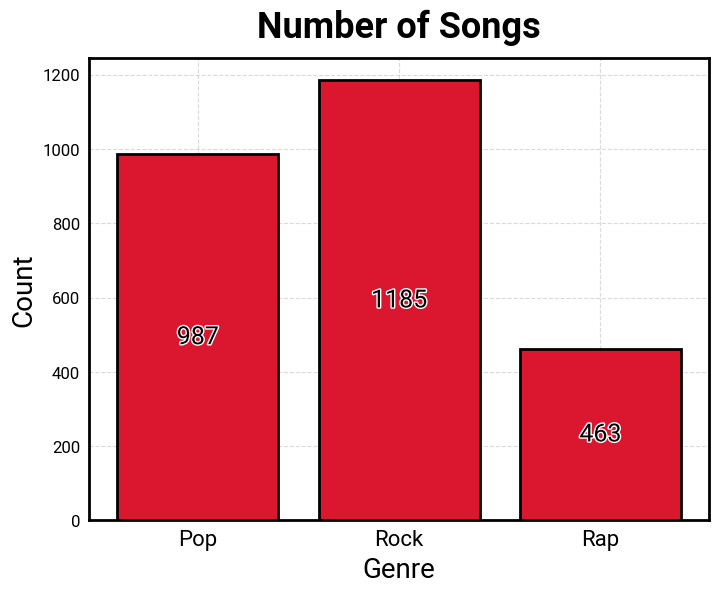

In [ ]:
# Changing default parameters of the axes
mpl.rc('axes',edgecolor='k')
mpl.rc('axes',linewidth='2')

# Creating a figure & axes
fig,ax = plt.subplots(figsize=(8,6))

# Modifying face-color and adding a grid
fig.set_facecolor('#ffffff')
ax.set_facecolor('#ffffff')
ax.set_axisbelow(True)
ax.grid(color='#2b2b2b',which='major',linestyle='--',alpha=0.35)

# Creating a dictionary with number of songs as values
dictLength = {'Pop':len(dfPop),'Rock':len(dfRock),'Rap':len(dfRap)}

# Plotting bar graph
bars = ax.bar(dictLength.keys(),dictLength.values(),color='#DB162F',ec='k',lw=2)
pe = path_effect_stroke(linewidth=2, foreground="w")
ax.bar_label(bars,label_type='center',fontsize=18,color='k',fontproperties=robotoMed,path_effects=pe)

# Modifying ticks and ticklabels
for ticklabel in ax.get_yticklabels():
    ticklabel.set_fontproperties(robotoMed)
    ticklabel.set_fontsize(12)
for ticklabel in ax.get_xticklabels():
    ticklabel.set_fontproperties(robotoMed)
    ticklabel.set_fontsize(16)
ax.tick_params(axis='both', which='major',labelcolor='k',length=3,color='#ffffff')

# Adding axis labels
ax.set_xlabel('Genre',color='k',fontsize=20,fontproperties=robotoMed)
ax.set_ylabel('Count',color='k',fontsize=20,fontproperties=robotoMed)

# Adding title
ax.set_title('Number of Songs',color='k',pad=15,fontsize=26,fontproperties=robotoBold)

plt.show()


## **Word Clouds**

Creating a set of stopwords to remove from wordclouds

In [ ]:
add_stopwords = {'know','got'}
STOPWORDS = STOPWORDS.union(add_stopwords)

Creating a custom colormap

In [ ]:
customcmap = LinearSegmentedColormap.from_list('custom cmap', ['#02bcfa','#ff0000'])

Creating a function to plot Word Clouds

In [ ]:
def plotWordCloud(data,ax):
    
    df = data.copy()
    # Removing next line characters
    df['Lyrics'] = df['Lyrics'].str.replace('\n',' ')
    # Creating a corpus
    textTokens = np.concatenate(df['Lyrics'].str.split().values)
    # Joining the tokens into a single string
    text = ' '.join(textTokens)
    # Using the wordcloud package to create wordclouds for the dataset
    wordcloud = WordCloud(
                            width = 600, height = 600,
                            background_color ='#ffffff',
                            stopwords = STOPWORDS,
                            relative_scaling=0.8,
                            min_font_size=10,
                            max_font_size=400,
                            prefer_horizontal=0.95, 
                            colormap=customcmap,
                            collocations=False,
                            font_path = "Fonts\Roboto\Roboto-Medium.ttf"
                          ).generate(text)

    # Plotting the WordCloud                    
    ax.imshow(wordcloud)

    ax.axis('off')

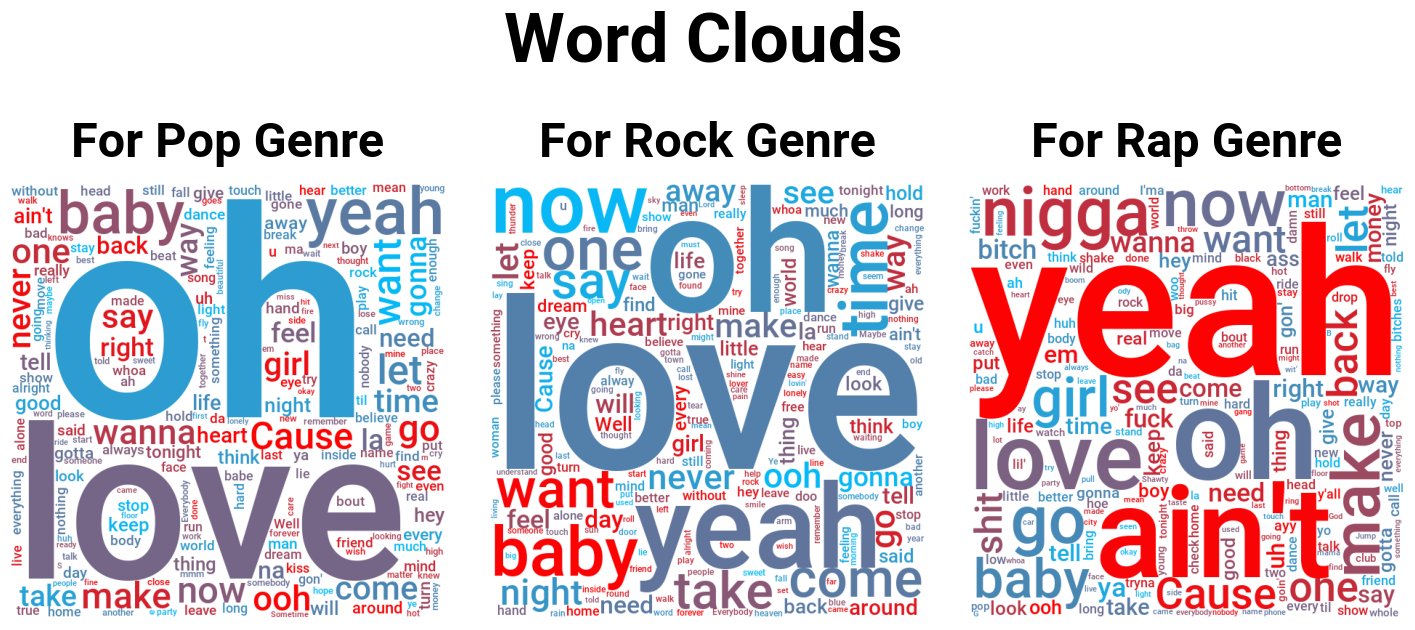

In [ ]:
# Creating a figure with multiple subplots
fig,axs = plt.subplots(1,3,figsize=(18,6))
plt.subplots_adjust(wspace=0.1)
# Setting the background color
fig.set_facecolor('#ffffff')
# Plotting the wordclouds for each genre on each subplot
plotWordCloud(dfPop,axs[0])
plotWordCloud(dfRock,axs[1])
plotWordCloud(dfRap,axs[2])
# Adding title for each subplot
axs[0].set_title('For Pop Genre',color='k',fontsize=35,fontweight='bold',pad=20,fontproperties=robotoBold)
axs[1].set_title('For Rock Genre',color='k',fontsize=35,fontweight='bold',pad=20,fontproperties=robotoBold)
axs[2].set_title('For Rap Genre',color='k',fontsize=35,fontweight='bold',pad=20,fontproperties=robotoBold)
# Adding title for the figure
fig.suptitle('Word Clouds',x=.51,y=1.15,color='k',fontsize=50,fontweight='bold',fontproperties=robotoBold,ha='center')

plt.show()

## **Top 10 Bigrams**

Creating a function to preprocess lyrics

In [ ]:
def preprocessLyrics(lyric):
    lyric = re.sub(r'[^\w\s]', '', lyric)
    return lyric

Creating a function to plot top 10 bigrams 

In [ ]:
def plotBigrams(data,ax):
    
    data = data.copy()
    # Preprocessing lyrics of all songs
    data['Lyrics'] = data['Lyrics'].apply(preprocessLyrics)
    # Joining all songs into a single string
    lyrics = ' '.join(data['Lyrics'].values)
    # Creating a corpus of all words in all songs
    corpus = lyrics.lower().split()
    # Creating a bigram corpus with bigrams as tuples
    bigramCorpus = [(corpus[idx],corpus[idx+1]) for idx in range(len(corpus)-1)]
    # Creating a dictionary with frequency of each bigram
    bigramCountDict = dict(Counter(bigramCorpus))
    
    # Creating a dataframe of bigram frequency 
    dfBigram = pd.DataFrame()
    dfBigram['Bigram'] = list(bigramCountDict.keys())
    dfBigram['Bigram Count'] = list(bigramCountDict.values())
    # Removing tuples with stopwords and getting top-10 bigrams
    dfBigram['Contains StopWord'] = dfBigram['Bigram'].apply(lambda x: any(stopword in x for stopword in STOPWORDS))
    top10Bigrams = dfBigram[dfBigram['Contains StopWord']==False].sort_values('Bigram Count',ascending=False).head(10)
    top10Bigrams['Bigram'] = top10Bigrams['Bigram'].apply(lambda x: ' '.join(x))
    top10Bigrams.reset_index(inplace=True,drop=True)
    
    # Setting face-color and grid
    ax.set_facecolor('#ffffff')
    ax.set_axisbelow(True)
    ax.grid(color='#2b2b2b',which='major',linestyle='--',alpha=0.35)
    # Reversing the axes
    ax.invert_yaxis()
    # Rescaling values to get color from color map
    rescale = lambda x: (x - np.min(x)) / (np.max(x) - np.min(x))
    # Plotting the bar graph
    ax.barh(top10Bigrams['Bigram'],top10Bigrams['Bigram Count'],color=customcmap(rescale(top10Bigrams['Bigram Count'])))
    ax.barh(top10Bigrams['Bigram'],top10Bigrams['Bigram Count'],color='None',edgecolor='k',ls='-',linewidth=2)
    # Modifying the ticks and ticklabels
    for ticklabel in ax.get_yticklabels():
        ticklabel.set_fontproperties(robotoMed)
        ticklabel.set_fontsize(22)
    for ticklabel in ax.get_xticklabels():
        ticklabel.set_fontproperties(robotoMed)
        ticklabel.set_fontsize(16)
    ax.tick_params(axis='both', which='major',labelcolor='k',length=0,color='#ffffff')
    # Adding the label for x-axis
    ax.set_xlabel('Count',color='k',fontsize=22,fontweight='bold',fontproperties=robotoMed)

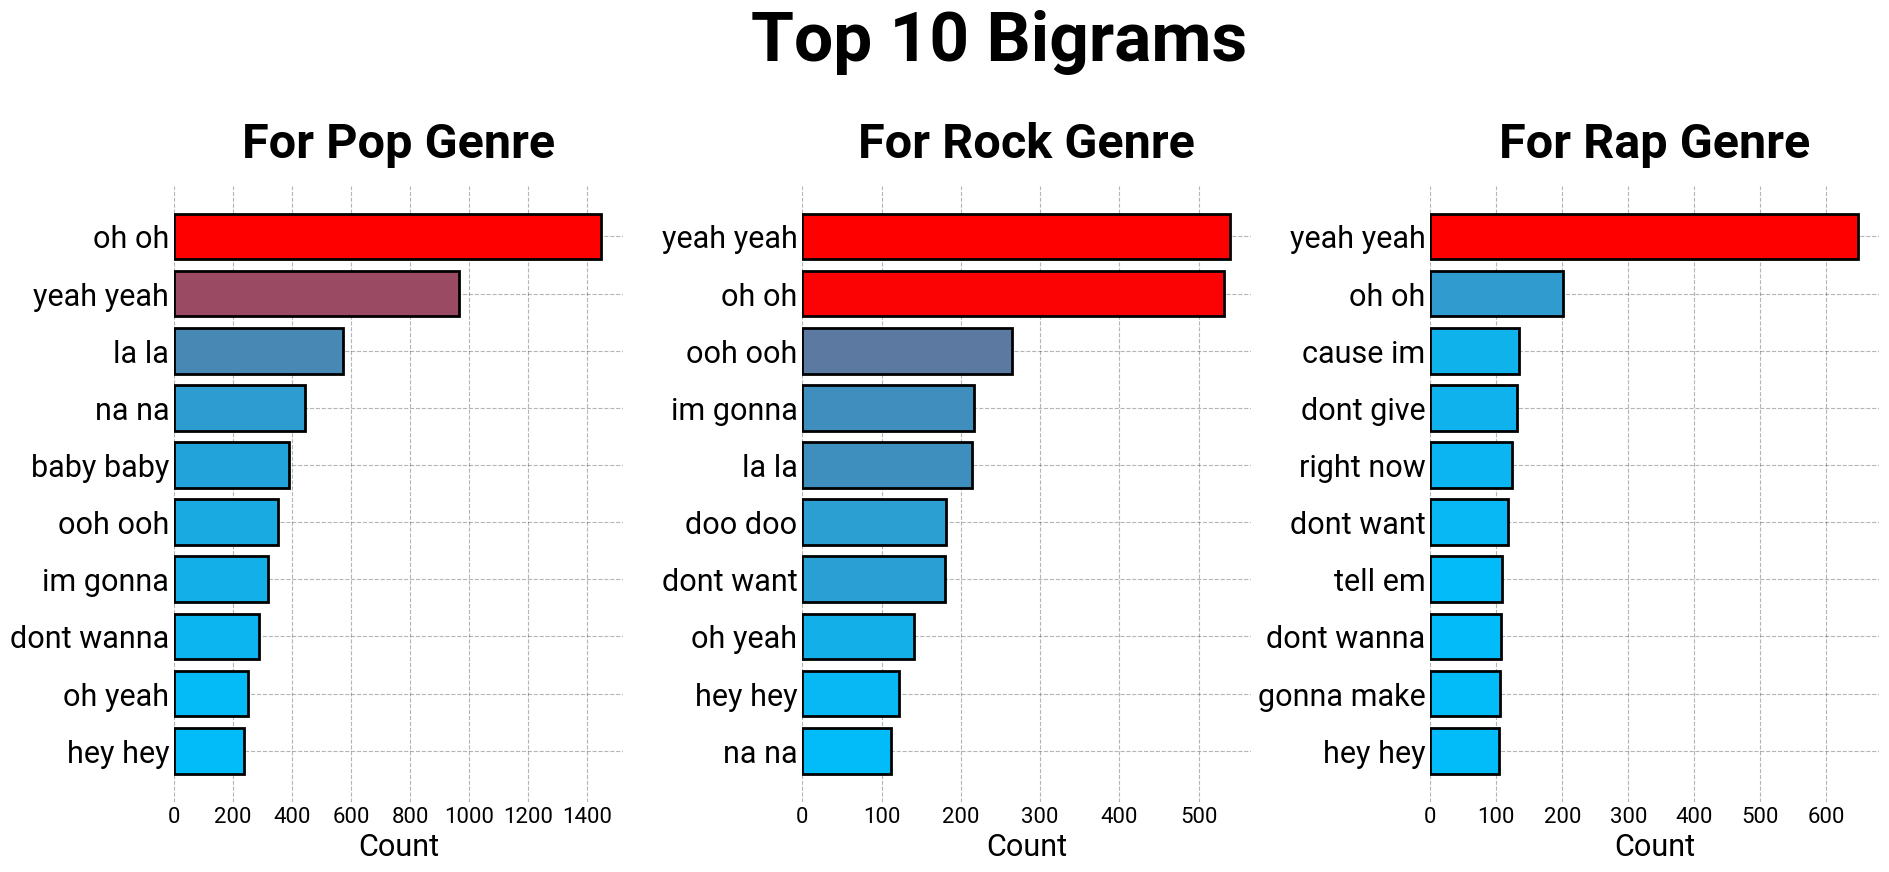

In [ ]:
# Modifying the spines of the axes
mpl.rc('axes',linewidth='0')
# Creating a figure with multiple subplots
fig,axs = plt.subplots(1,3,figsize=(22,8))
plt.subplots_adjust(wspace=0.4)
# Setting the face-color
fig.set_facecolor('#ffffff')
# Plotting bigrams of each genre on each axes
plotBigrams(dfPop,axs[0])
plotBigrams(dfRock,axs[1])
plotBigrams(dfRap,axs[2])
# Adding title for each axes
axs[0].set_title('For Pop Genre',color='k',fontsize=35,fontweight='bold',pad=20,fontproperties=robotoBold)
axs[1].set_title('For Rock Genre',color='k',fontsize=35,fontweight='bold',pad=20,fontproperties=robotoBold)
axs[2].set_title('For Rap Genre',color='k',fontsize=35,fontweight='bold',pad=20,fontproperties=robotoBold)
# Adding the title for the figure
fig.suptitle('Top 10 Bigrams',y=1.10,color='k',fontsize=50,fontweight='bold',fontproperties=robotoBold)

plt.show()


## **Custom Metrics**

Creating a function to calculate custom metrics

In [ ]:
def getMetrics(data):
    data = data.copy()
    # Calculating custom metrics for each song
    # Calculating number of lines per song
    data['No. of Lines'] = data['Lyrics'].apply(lambda song:(song.count('\n')+1))
    # Calculating average line length of each song
    data['Line Length'] = data['Lyrics'].apply(lambda song:len(song.split())/(song.count('\n')+1))
    # Calculating number of each unique words in each song divided by total number of words in the song
    data['Vocab Richness'] = data['Lyrics'].apply(lambda song:len(np.unique(song.split()))/song.split().__len__())
    # Calculating number of unique words in the entire data divided by total number of words in the data
    data['Lyrics'] = data['Lyrics'].apply(preprocessLyrics)
    lyrics = ' '.join(data['Lyrics'].values)
    corpus = lyrics.lower().split()
    genreVocabRich = len(np.unique(corpus))/len(corpus)
    
    # Creating a dictionary to return the custom metrics of the entire dataset and returning it
    metricsKey = ['Avg No. of Lines','Avg Line Length','Avg Song Vocab Richness','Avg Genre Vocab Richness']
    metricsVal = [data['No. of Lines'].mean(),data['Line Length'].mean(),data['Vocab Richness'].mean(),genreVocabRich]
    dictMetrics = dict(zip(metricsKey,metricsVal))
    
    return dictMetrics

Creating a dataframe with custom metrics of all the genres

In [ ]:
metrics = pd.DataFrame.from_dict(getMetrics(dfPop),orient='index').T 
metrics = metrics.append(getMetrics(dfRock),ignore_index=True)
metrics = metrics.append(getMetrics(dfRap),ignore_index=True)
metrics['Genre'] = ['Pop','Rock','Rap']
metrics = metrics.set_index('Genre')
metrics = metrics.round(2)

Plotting a table with custom metrics of all the genres

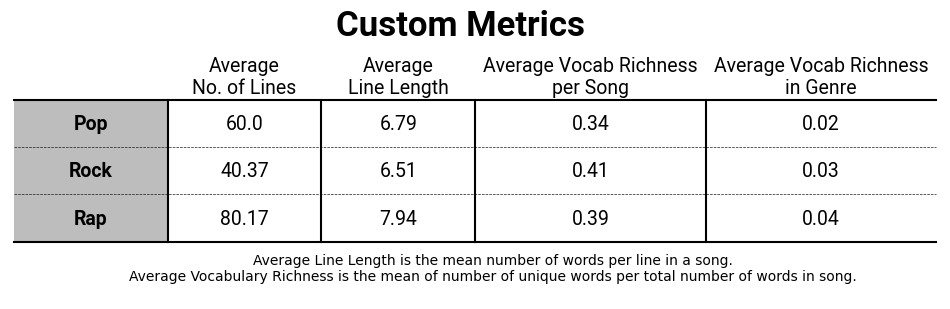

In [ ]:
# Creating a figure and axis
fig, ax = plt.subplots(figsize=(12, 2.5))

# Setting the face-colors of figure and axis
fig.set_facecolor('#ffffff')
ax.set_facecolor('#ffffff')

# Using the table function to plot the table
col_defs = ([
                ColumnDefinition(name="Genre",title="",textprops={"ha": "center","fontproperties":robotoBold},width=1,border="right"),
                ColumnDefinition(name="Avg No. of Lines",title="Average\nNo. of Lines",textprops={"ha": "center"},width=1,border="right"),
                ColumnDefinition(name="Avg Line Length",title="Average\nLine Length",textprops={"ha": "center"},width=1,border="right"),
                ColumnDefinition(name="Avg Song Vocab Richness",title="Average Vocab Richness\nper Song",textprops={"ha": "center"},width=1.5,border="right"),
                ColumnDefinition(name="Avg Genre Vocab Richness",title="Average Vocab Richness\nin Genre",textprops={"ha": "center"},width=1.5),
            ])


tab = Table(metrics,
            column_definitions=col_defs,
            row_dividers=True,
            footer_divider=True,
            ax=ax,
            textprops={"fontsize": 14,"fontproperties":robotoMed,'color':'k'},
            row_divider_kw={"linewidth": 0.5, "linestyle": "--",'color':'#181818'},
            col_label_divider_kw={"linewidth": 1.5, "linestyle": "-",'color':'k'},
            column_border_kw={"linewidth": 1.5, "linestyle": "-",'color':'k'},
            footer_divider_kw={"linewidth": 1.5, "linestyle": "-",'color':'k'},
            )

tab.columns['Genre'].set_facecolor('#bdbdbd')

# Adding the title for the figure 
fig.suptitle('Custom Metrics',y=1.05,color='k',fontsize=25,fontweight='bold',fontproperties=robotoBold)
# Adding end-note
ax.text(3,4.15,
        '''
        Average Line Length is the mean number of words per line in a song.
        Average Vocabulary Richness is the mean of number of unique words per total number of words in song.
        ''', ha='center')

plt.show()

# **Data Pre-processing**

## **Data processing for Baseline Model**

From a list of tokens which represent words, <br>
```
TokenList = [73, 49, 3, 80, 528, 5, 5407, 28, ......, 2, 1, 54, 15, 295, 28, 2, 75]
```
The input and output for our models will be as follows, <br>
```
X = [[73, 49, 3, ...],[9, 23, 45, ...],[8, 80, 505, ...], ..... ]
Y = [[49, 3, 80, ...],[23, 45, 1, ...],[80, 505, 19,...], ..... ]

```
Here, X and Y consist sub-lists of the main `TokenList`, each of length `windowSize` where Y consists the sub-lists shifted by one position

Creating a function to convert a list of tokens into sequence windows and next tokens

In [ ]:
def createWindows(tokenList,windowSize = 128):
    
    # New length of token list to perfectly divide into sequences of window size
    newLength = (len(tokenList)//windowSize)*windowSize
    
    # New token lists
    tokenList = tokenList[:newLength]
    
    # Empty lists to store sequences of tokens and output tokens
    inputSequences = []
    outputSequences  = []
    # Iterating through the list of tokens
    for i in range(0,len(tokenList)-windowSize,windowSize):
        # Appending the window of input sequences to the list
        inputSequences.append(tokenList[i:i+windowSize])
        # Appending the window of output sequences to the list
        outputSequences.append(tokenList[i+1:i+windowSize+1])
    
    # Returning a tuple of sequence windows and outputs
    return (inputSequences,outputSequences)    

Creating a function to make tensorflow datasets for the Baseline Model 

In [ ]:
def preprocessBaseline(file_path,batch_size=64,windowSize=128):
    
    # Reading the data and storing in a dataframe
    df = pd.read_csv(file_path)
    # Separating new-line character
    df['Lyrics'] = df['Lyrics'].str.replace('\n',' \n ')
    # Adding start and end tokens
    df['Lyrics'] = '<s> '+df['Lyrics']+' </s>' 
    
    # -----------------------------------------------------
    # Tokenization
    # -----------------------------------------------------
    
    # Initializing a tensorflow tokenizer
    tokenizer = tf.keras.preprocessing.text.Tokenizer(
                                                      num_words=None,       # No maximum number of words
                                                      filters='()[]{}',     # Filters to remove braces
                                                      lower=True,           # Converting to lowercase
                                                      split=' ',            # Splitting on whitespace
                                                     )
    # Fitting on the text
    tokenizer.fit_on_texts(df['Lyrics'])
    # Converting each song to tokens and storing i the dataframe
    df['Tokens'] = tokenizer.texts_to_sequences(df["Lyrics"])
    
    # Combining all the tokens into a single list
    tokenList = df['Tokens'].sum()
    
    # Creating input and output sequences
    X,y = createWindows(tokenList,windowSize=windowSize)
    
    # -----------------------------------------------------
    # Tensorflow Datasets
    # -----------------------------------------------------
    
    # Splitting into train and vaidation sets
    X_train, X_val, y_train, y_val = train_test_split(X,y,test_size=0.2,random_state=23)
    
    # For train set
    # Converting input & output tokens into tensorflow constants    
    input_train = tf.constant(X_train)
    output_train = tf.constant(y_train)
    # Converting into tensorflow dataset
    trainDataset = tf.data.Dataset.from_tensor_slices((input_train, output_train))
    # Shuffling, converting into batches & optimizing
    trainDataset = trainDataset.shuffle(buffer_size=len(X_train))
    trainDataset = trainDataset.batch(batch_size)
    trainDataset = trainDataset.prefetch(tf.data.AUTOTUNE)
    
    # For validation set
    # Converting input & output tokens into tensorflow constants    
    input_val = tf.constant(X_val)
    output_val = tf.constant(y_val)
    # Converting into tensorflow dataset
    valDataset = tf.data.Dataset.from_tensor_slices((input_val, output_val))
    # Shuffling, converting into batches & optimizing
    valDataset = valDataset.shuffle(buffer_size=len(X_val))
    valDataset = valDataset.batch(batch_size)
    valDataset = valDataset.prefetch(tf.data.AUTOTUNE)
    
    # Returning the training and validation datasets
    return tokenizer, trainDataset, valDataset

## **Data processing for 🤗 Transformer models**

For the transformer models GPT2 and RoBERTa, we are going to take all the lyrics in a given dataset (whether that be a genre dataset or an artist dataset), tokenize them and concatenate them. This combined lyrics tokenized sequence will be then split into mini sequences of a fixed block size. Ideally, for lyrics generation, a block size of $256$ or $512$ tokens would've been the better choice, but due to GPU RAM limitations, the chosen block size here is $128$. These block sized sequences would be our model inputs $X$ and model outputs $Y$. <br><br> 
For RoBERTa, random tokens would be masked using Data Collator, whereas for GPT2, the tokens in $Y$ would be shifted by one position to the right. The shifting does not need to be done explicitly since CausalLM models in the 🤗 Transformers library automatically apply right-shifting to the inputs. <br><br>
Below, we define all the functions we will need to load a dataset from its path and process it in order to feed it to the transformer models.

In [ ]:
# Defining a function that will load datasets given their path
def get_dataset(path):
  dataset = load_dataset("csv", data_files = path)
  dataset = dataset["train"].train_test_split(train_size = 0.8)
  return dataset

In [ ]:
# Loading the tokenizers
tokenizer_gpt2 = AutoTokenizer.from_pretrained("distilgpt2")
tokenizer_roberta = AutoTokenizer.from_pretrained("distilroberta-base")

In [ ]:
# Defining a function that will return tokenized lyrics using GPT2 tokenizer
def tokenize_lyrics_gpt2(song):
  tokenized_lyrics = tokenizer_gpt2(song['Lyrics'])
  return tokenized_lyrics

# Defining a function that will return tokenized lyrics using RoBERTa tokenizer
def tokenize_lyrics_roberta(song):
  tokenized_lyrics = tokenizer_roberta(song['Lyrics'])
  return tokenized_lyrics

# Defining a function that will tokenize lyrics of all the songs for a given dataset
def tokenize_dataset(dataset, tokenize_lyrics):
  tokenized_dataset = dataset.map(tokenize_lyrics, batched = True, num_proc = 7, remove_columns=['Song Name', 'Lyrics'])
  return tokenized_dataset

In [ ]:
# Defining a block size which will act as the chunk of lyrics we will be taking from the entire combined lyrics corpus
block_size = 128

# Defining a function that will generate lyrics dataset (block sized) for language modelling
def language_modelling_ds(lyrics):
    # Combining the lyrics (tokens) of all the songs
    combined_lyrics = {k: sum(lyrics[k], []) for k in lyrics.keys()}
    # Calculating the length of the combined lyrics (tokenized)
    combined_lyrics_length = len(combined_lyrics['input_ids'])
    # Dropping the extra tokens
    combined_lyrics_length = (combined_lyrics_length // block_size) * block_size
    # Making a new dataset by dividing the combined lyrics tokens into blocks of size block_size
    dataset = {k: [v[i : i + block_size] for i in range(0, combined_lyrics_length, block_size)] for k, v in combined_lyrics.items()}
    # Getting the labels which will be same as the input but shifted by one position. Since 🤗 does the shift by itself, manual shifting of the labels isn't required
    dataset['labels'] = dataset['input_ids'].copy()
    return dataset

In [ ]:
# Defining a function that will tokenize all the lyrics, combine them and return a dataset of block sized tokens from the given dataset

def build_dataset(dataset, tokenizer_fn):

  # Getting tokenized lyrics for all the songs in the dataset 
  tokenized_ds = tokenize_dataset(dataset, tokenizer_fn)
  # Preparing the tokenized dataset for language modelling
  lmds = tokenized_ds.map(language_modelling_ds, batched = True, batch_size = 200, num_proc = 4)

  return lmds

Note that RoBERTa is a Masked Language Model. Hence we will need to randomly mask some of the tokens. The masking can be easily accomplished by using Data Collator for Language Modeling.

In [ ]:
# Using Data Collator we will mask tokens randomly
data_collator = DataCollatorForLanguageModeling(tokenizer = tokenizer_roberta, mlm_probability = 0.15, return_tensors = "tf")

# **Modeling**

## **Baseline Models**

Creating a function to create a Baseline model

In [ ]:
def createBaselineModel(
                            file_path, 
                            learning_rate=0.001,
                            n_epochs=10,
                            display_summary = False,
                            display_plot=False
                        ):
    # Using the preprocessing function to preprocess the dataset
    tokenizer,trainData,valData = preprocessBaseline(file_path)
    # Creating  the baseline model
    inputs = tf.keras.layers.Input(shape=(None,),name='InputLayer',dtype=tf.int32)
    embLayer = tf.keras.layers.Embedding(input_dim = len(tokenizer.word_index)+1, output_dim = 300,name='EmbeddingLayer')(inputs) 
    LSTM1 = tf.keras.layers.LSTM(
                                    256,
                                    name='LSTM1',return_sequences=True,
                                    kernel_regularizer=tf.keras.regularizers.l2(0.01)
                                 )(embLayer)
    dropout = tf.keras.layers.Dropout(0.2)(LSTM1)
    outputs = tf.keras.layers.Dense(len(tokenizer.word_index)+1,activation='softmax',name='OutputLayer')(dropout)
    model = tf.keras.Model(inputs=inputs,outputs=outputs)
    # Compiling the model
    loss = tf.keras.losses.SparseCategoricalCrossentropy()
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(loss=loss,optimizer=optimizer)
    # Display the model summary and model plot
    if display_summary == True:
        print(model.summary())
    if display_plot == True:
        tf.keras.utils.plot_model(model)
    
    K.clear_session()
    # Fitting the model
    history = model.fit(trainData,validation_data=valData,epochs=n_epochs)
     
    return model,history 

### **Genre: Pop**

In [ ]:
baseline_pop, baseline_pop_history = createBaselineModel(pop_filepath)

Epoch 1/10
45/45 [==============================] - 9s 100ms/step - loss: 9.0236 - val_loss: 6.4843
Epoch 2/10
45/45 [==============================] - 4s 95ms/step - loss: 6.1861 - val_loss: 6.0970
Epoch 3/10
45/45 [==============================] - 4s 90ms/step - loss: 6.0613 - val_loss: 6.0811
Epoch 4/10
45/45 [==============================] - 4s 88ms/step - loss: 6.0496 - val_loss: 6.0767
Epoch 5/10
45/45 [==============================] - 4s 90ms/step - loss: 6.0416 - val_loss: 6.0743
Epoch 6/10
45/45 [==============================] - 4s 94ms/step - loss: 6.0349 - val_loss: 6.0742
Epoch 7/10
45/45 [==============================] - 4s 94ms/step - loss: 6.0293 - val_loss: 6.0722
Epoch 8/10
45/45 [==============================] - 4s 94ms/step - loss: 6.0249 - val_loss: 6.0683
Epoch 9/10
45/45 [==============================] - 4s 95ms/step - loss: 6.0207 - val_loss: 6.0636
Epoch 10/10
45/45 [==============================] - 4s 96ms/step - loss: 6.0165 - val_loss: 6.0607


### **Genre: Rock**

In [ ]:
baseline_rock, baseline_rock_history = createBaselineModel(rock_filepath)

Epoch 1/10
35/35 [==============================] - 6s 116ms/step - loss: 9.5990 - val_loss: 6.8553
Epoch 2/10
35/35 [==============================] - 3s 90ms/step - loss: 6.3702 - val_loss: 6.1517
Epoch 3/10
35/35 [==============================] - 3s 92ms/step - loss: 6.0769 - val_loss: 6.0977
Epoch 4/10
35/35 [==============================] - 3s 95ms/step - loss: 6.0513 - val_loss: 6.0907
Epoch 5/10
35/35 [==============================] - 3s 94ms/step - loss: 6.0437 - val_loss: 6.0875
Epoch 6/10
35/35 [==============================] - 3s 93ms/step - loss: 6.0398 - val_loss: 6.0868
Epoch 7/10
35/35 [==============================] - 3s 93ms/step - loss: 6.0341 - val_loss: 6.0874
Epoch 8/10
35/35 [==============================] - 3s 94ms/step - loss: 6.0305 - val_loss: 6.0897
Epoch 9/10
35/35 [==============================] - 3s 94ms/step - loss: 6.0253 - val_loss: 6.0861
Epoch 10/10
35/35 [==============================] - 3s 95ms/step - loss: 6.0228 - val_loss: 6.0833


### **Genre: Rap**

In [ ]:
baseline_rap, baseline_rap_history = createBaselineModel(rap_filepath)

Epoch 1/10
33/33 [==============================] - 5s 121ms/step - loss: 10.3099 - val_loss: 7.3943
Epoch 2/10
33/33 [==============================] - 4s 113ms/step - loss: 6.8377 - val_loss: 6.5725
Epoch 3/10
33/33 [==============================] - 3s 105ms/step - loss: 6.4817 - val_loss: 6.4994
Epoch 4/10
33/33 [==============================] - 3s 92ms/step - loss: 6.4476 - val_loss: 6.4981
Epoch 5/10
33/33 [==============================] - 3s 98ms/step - loss: 6.4390 - val_loss: 6.4970
Epoch 6/10
33/33 [==============================] - 4s 112ms/step - loss: 6.4355 - val_loss: 6.5011
Epoch 7/10
33/33 [==============================] - 4s 113ms/step - loss: 6.4302 - val_loss: 6.5001
Epoch 8/10
33/33 [==============================] - 4s 113ms/step - loss: 6.4260 - val_loss: 6.5023
Epoch 9/10
33/33 [==============================] - 4s 114ms/step - loss: 6.4222 - val_loss: 6.5034
Epoch 10/10
33/33 [==============================] - 4s 114ms/step - loss: 6.4184 - val_loss: 6.5027


## **🤗 RoBERTa**

Since we'll be building three models (one for each genre Pop, Rock and Rap), it would be easier to define a function that will build and compile a model as well as prepare the dataset for it. We'll be calling this function each time we build a RoBERTa model for a particular genre or artist.

In [ ]:
# Defining a function that will create a model and prepare the dataset accordingly
def createRoBERTaModel(dataset, model_checkpoint = "distilroberta-base", learning_rate = 0.003):

  model = TFAutoModelForMaskedLM.from_pretrained(model_checkpoint)
  model.compile(optimizer = keras.optimizers.Adam(learning_rate = learning_rate), jit_compile = True)

  data_train = model.prepare_tf_dataset(dataset['train'], shuffle = True, batch_size = 64, collate_fn = data_collator)
  data_val = model.prepare_tf_dataset(dataset['test'], shuffle = True, batch_size = 64, collate_fn = data_collator)
  
  return data_train, data_val, model

### **Genre: Pop**

In [ ]:
# Loading the Pop dataset from its path
pop_ds = get_dataset(pop_filepath)

# Building the Pop dataset ready to go for training 
pop_lmds = build_dataset(pop_ds, tokenize_lyrics_roberta)

clear_output()

In [ ]:
# Creating the Pop model and associated Pop dataset
pop_train, pop_val, pop_roberta_model = createRoBERTaModel(pop_lmds)

Downloading:   0%|          | 0.00/487M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFRobertaForMaskedLM.

All the layers of TFRobertaForMaskedLM were initialized from the model checkpoint at distilroberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForMaskedLM for predictions without further training.
No loss specified in compile() - the model's internal loss computation will be used as the loss. Don't panic - this is a common way to train TensorFlow models in Transformers! To disable this behaviour please pass a loss argument, or explicitly pass `loss=None` if you do not want your model to compute a loss.
You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


In [ ]:
# Callback
callback = tf.keras.callbacks.EarlyStopping(patience = 2)
# Fitting the Pop model
history_roberta_pop = pop_roberta_model.fit(pop_train, validation_data = pop_val, epochs = 10, callbacks = callback)

Epoch 1/10
55/55 [==============================] - 120s 1s/step - loss: 6.9601 - val_loss: 6.2485
Epoch 2/10
55/55 [==============================] - 76s 1s/step - loss: 6.1238 - val_loss: 6.2606
Epoch 3/10
55/55 [==============================] - 75s 1s/step - loss: 6.0561 - val_loss: 6.2256
Epoch 4/10
55/55 [==============================] - 75s 1s/step - loss: 6.0428 - val_loss: 6.2094
Epoch 5/10
55/55 [==============================] - 75s 1s/step - loss: 6.0264 - val_loss: 6.1776
Epoch 6/10
55/55 [==============================] - 75s 1s/step - loss: 6.0060 - val_loss: 6.1721
Epoch 7/10
55/55 [==============================] - 75s 1s/step - loss: 5.9915 - val_loss: 6.1768
Epoch 8/10
55/55 [==============================] - 75s 1s/step - loss: 5.9882 - val_loss: 6.1498
Epoch 9/10
55/55 [==============================] - 75s 1s/step - loss: 5.9776 - val_loss: 6.1626
Epoch 10/10
55/55 [==============================] - 75s 1s/step - loss: 5.9548 - val_loss: 6.1513


### **Genre: Rock**

In [ ]:
# Loading the Rock dataset from its path
rock_ds = get_dataset(rock_filepath)

# Building the Rock dataset ready to go for training 
rock_lmds = build_dataset(rock_ds, tokenize_lyrics_roberta)

clear_output()

In [ ]:
# Creating the Rock model and associated Rock dataset
rock_train, rock_val, rock_roberta_model = createRoBERTaModel(rock_lmds)

All model checkpoint layers were used when initializing TFRobertaForMaskedLM.

All the layers of TFRobertaForMaskedLM were initialized from the model checkpoint at distilroberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForMaskedLM for predictions without further training.
No loss specified in compile() - the model's internal loss computation will be used as the loss. Don't panic - this is a common way to train TensorFlow models in Transformers! To disable this behaviour please pass a loss argument, or explicitly pass `loss=None` if you do not want your model to compute a loss.


In [ ]:
# Callback
callback = tf.keras.callbacks.EarlyStopping(patience = 2)

# Fitting the Rock model
history_roberta_rock = rock_roberta_model.fit(rock_train, validation_data = rock_val, epochs = 10, callbacks = callback)

Epoch 1/10
41/41 [==============================] - 80s 1s/step - loss: 8.4123 - val_loss: 6.5582
Epoch 2/10
41/41 [==============================] - 56s 1s/step - loss: 6.2552 - val_loss: 6.4172
Epoch 3/10
41/41 [==============================] - 56s 1s/step - loss: 6.1702 - val_loss: 6.3275
Epoch 4/10
41/41 [==============================] - 56s 1s/step - loss: 6.1401 - val_loss: 6.3093
Epoch 5/10
41/41 [==============================] - 56s 1s/step - loss: 6.1267 - val_loss: 6.3078
Epoch 6/10
41/41 [==============================] - 56s 1s/step - loss: 6.1077 - val_loss: 6.2907
Epoch 7/10
41/41 [==============================] - 56s 1s/step - loss: 6.0866 - val_loss: 6.3454
Epoch 8/10
41/41 [==============================] - 56s 1s/step - loss: 6.0695 - val_loss: 6.2692
Epoch 9/10
41/41 [==============================] - 56s 1s/step - loss: 6.0594 - val_loss: 6.3093
Epoch 10/10
41/41 [==============================] - 56s 1s/step - loss: 6.0724 - val_loss: 6.2702


### **Genre: Rap**

In [ ]:
# Loading the Rap dataset from its path
rap_ds = get_dataset(rap_filepath)

# Building the Rap dataset ready to go for training 
rap_lmds = build_dataset(rap_ds, tokenize_lyrics_roberta)

clear_output()

In [ ]:
# Creating the Rap model and associated Rap dataset
rap_train, rap_val, rap_roberta_model = createRoBERTaModel(rap_lmds)

All model checkpoint layers were used when initializing TFRobertaForMaskedLM.

All the layers of TFRobertaForMaskedLM were initialized from the model checkpoint at distilroberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForMaskedLM for predictions without further training.
No loss specified in compile() - the model's internal loss computation will be used as the loss. Don't panic - this is a common way to train TensorFlow models in Transformers! To disable this behaviour please pass a loss argument, or explicitly pass `loss=None` if you do not want your model to compute a loss.


In [ ]:
# Callback
callback = tf.keras.callbacks.EarlyStopping(patience = 2)

# Fitting the Rap model
history_roberta_rap = rap_roberta_model.fit(rap_train, validation_data = rap_val, epochs = 10, callbacks = callback)

Epoch 1/10
42/42 [==============================] - 80s 1s/step - loss: 7.8906 - val_loss: 6.6066
Epoch 2/10
42/42 [==============================] - 57s 1s/step - loss: 6.4932 - val_loss: 6.4950
Epoch 3/10
42/42 [==============================] - 57s 1s/step - loss: 6.4291 - val_loss: 6.5062
Epoch 4/10
42/42 [==============================] - 57s 1s/step - loss: 6.3818 - val_loss: 6.5235


## **🤗 GPT2 Models**

Since we'll be building three models (one for each genre Pop, Rock and Rap), it would be easier to define a function that will build and compile a model as well as prepare the dataset for it. We'll be calling this function each time we build a GPT2 model for a particular genre or artist.

In [ ]:
# Defining a function that will create a model and prepare the dataset accordingly
def createGPTModel(dataset, model_checkpoint, learning_rate = 0.003):

  model = TFAutoModelForCausalLM.from_pretrained(model_checkpoint)
  model.compile(optimizer = keras.optimizers.Adam(learning_rate = learning_rate), jit_compile = True)

  data_train = model.prepare_tf_dataset(dataset['train'], shuffle = True, batch_size = 64)
  data_val = model.prepare_tf_dataset(dataset['test'], shuffle = True, batch_size = 64)
  
  return data_train, data_val, model

### **Genre: Pop**

In [ ]:
# Loading the Pop dataset from its path
pop_ds = get_dataset(pop_filepath)

# Building the Pop dataset ready to go for training 
pop_lmds = build_dataset(pop_ds, tokenize_lyrics_gpt2)

clear_output()

In [ ]:
# Creating the Pop model and associated Pop dataset
pop_train, pop_val, pop_gpt2_model = createGPTModel(pop_lmds, model_checkpoint = "distilgpt2")

All model checkpoint layers were used when initializing TFGPT2LMHeadModel.

All the layers of TFGPT2LMHeadModel were initialized from the model checkpoint at distilgpt2.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2LMHeadModel for predictions without further training.
No loss specified in compile() - the model's internal loss computation will be used as the loss. Don't panic - this is a common way to train TensorFlow models in Transformers! To disable this behaviour please pass a loss argument, or explicitly pass `loss=None` if you do not want your model to compute a loss.


In [ ]:
# Callback
callback = tf.keras.callbacks.EarlyStopping(patience = 2)
# Fitting the Pop model
history_gpt2_pop = pop_gpt2_model.fit(pop_train, validation_data = pop_val, epochs = 10, callbacks = callback)

Epoch 1/10
55/55 [==============================] - 114s 1s/step - loss: 5.4024 - val_loss: 4.3873
Epoch 2/10
55/55 [==============================] - 73s 1s/step - loss: 3.9212 - val_loss: 3.4664
Epoch 3/10
55/55 [==============================] - 72s 1s/step - loss: 2.9307 - val_loss: 3.1274
Epoch 4/10
55/55 [==============================] - 73s 1s/step - loss: 2.3561 - val_loss: 3.1571
Epoch 5/10
55/55 [==============================] - 73s 1s/step - loss: 1.9354 - val_loss: 3.2686


### **Genre: Rock**

In [ ]:
# Loading the Rock dataset from its path
rock_ds = get_dataset(rock_filepath)

# Building the Rock dataset ready to go for training 
rock_lmds = build_dataset(rock_ds, tokenize_lyrics_gpt2)

clear_output()

In [ ]:
# Creating the Rock model and associated Rock dataset
rock_train, rock_val, rock_gpt2_model = createGPTModel(rock_lmds, model_checkpoint = "distilgpt2")

Downloading:   0%|          | 0.00/328M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFGPT2LMHeadModel.

All the layers of TFGPT2LMHeadModel were initialized from the model checkpoint at distilgpt2.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2LMHeadModel for predictions without further training.
No loss specified in compile() - the model's internal loss computation will be used as the loss. Don't panic - this is a common way to train TensorFlow models in Transformers! To disable this behaviour please pass a loss argument, or explicitly pass `loss=None` if you do not want your model to compute a loss.


In [ ]:
# Callback
callback = tf.keras.callbacks.EarlyStopping(patience = 2)

# Fitting the Rock model
history_gpt2_rock = rock_gpt2_model.fit(rock_train, validation_data = rock_val, epochs = 10, callbacks = callback)

Epoch 1/10
41/41 [==============================] - 99s 2s/step - loss: 5.8119 - val_loss: 5.0350
Epoch 2/10
41/41 [==============================] - 58s 1s/step - loss: 4.5716 - val_loss: 4.4843
Epoch 3/10
41/41 [==============================] - 59s 1s/step - loss: 3.8247 - val_loss: 3.6602
Epoch 4/10
41/41 [==============================] - 59s 1s/step - loss: 3.0191 - val_loss: 3.3374
Epoch 5/10
41/41 [==============================] - 60s 1s/step - loss: 2.5254 - val_loss: 3.3434
Epoch 6/10
41/41 [==============================] - 58s 1s/step - loss: 2.1460 - val_loss: 3.4137


### **Genre: Rap**

In [ ]:
# Loading the Rap dataset from its path
rap_ds = get_dataset(rap_filepath)

# Building the Rap dataset ready to go for training 
rap_lmds = build_dataset(rap_ds, tokenize_lyrics_gpt2)

clear_output()

In [ ]:
# Creating the Rap model and associated Rap dataset
rap_train, rap_val, rap_gpt2_model = createGPTModel(rap_lmds, model_checkpoint = "distilgpt2")

All model checkpoint layers were used when initializing TFGPT2LMHeadModel.

All the layers of TFGPT2LMHeadModel were initialized from the model checkpoint at distilgpt2.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2LMHeadModel for predictions without further training.
No loss specified in compile() - the model's internal loss computation will be used as the loss. Don't panic - this is a common way to train TensorFlow models in Transformers! To disable this behaviour please pass a loss argument, or explicitly pass `loss=None` if you do not want your model to compute a loss.


In [ ]:
# Callback
callback = tf.keras.callbacks.EarlyStopping(patience = 2)

# Fitting the Rap model
history_gpt2_rap = rap_gpt2_model.fit(rap_train, validation_data = rap_val, epochs = 10, callbacks = callback)

Epoch 1/10
42/42 [==============================] - 102s 2s/step - loss: 6.2681 - val_loss: 5.3814
Epoch 2/10
42/42 [==============================] - 60s 1s/step - loss: 4.9465 - val_loss: 4.8081
Epoch 3/10
42/42 [==============================] - 60s 1s/step - loss: 4.3754 - val_loss: 4.4434
Epoch 4/10
42/42 [==============================] - 61s 1s/step - loss: 3.7584 - val_loss: 4.0728
Epoch 5/10
42/42 [==============================] - 60s 1s/step - loss: 3.1895 - val_loss: 3.9418
Epoch 6/10
42/42 [==============================] - 60s 1s/step - loss: 2.7123 - val_loss: 3.9930
Epoch 7/10
42/42 [==============================] - 61s 1s/step - loss: 2.3029 - val_loss: 4.1085


# **Evaluation**

Creating dictionaries of loss and validation loss for each genre-based model

In [ ]:
baselineLossKeys = ['Pop Loss','Pop Val Loss','Rock Loss','Rock Val Loss','Rap Loss','Rap Val Loss']
baselineLossVals = [min(baseline_pop_history.history['loss']),min(baseline_pop_history.history['val_loss']),min(baseline_rock_history.history['loss']),min(baseline_rock_history.history['val_loss']),min(baseline_rap_history.history['loss']),min(baseline_rap_history.history['val_loss'])]
baselineLossDict = dict(zip(baselineLossKeys,baselineLossVals))

robertaLossKeys = ['Pop Loss','Pop Val Loss','Rock Loss','Rock Val Loss','Rap Loss','Rap Val Loss']
robertaLossVals = [min(history_roberta_pop.history['loss']),min(history_roberta_pop.history['val_loss']),min(history_roberta_rock.history['loss']),min(history_roberta_rock.history['val_loss']),min(history_roberta_rap.history['loss']),min(history_roberta_rap.history['val_loss'])]
robertaLossDict = dict(zip(robertaLossKeys,robertaLossVals))

gptLossKeys = ['Pop Loss','Pop Val Loss','Rock Loss','Rock Val Loss','Rap Loss','Rap Val Loss']
gptLossVals = [min(history_gpt2_pop.history['loss']),min(history_gpt2_pop.history['val_loss']),min(history_gpt2_rock.history['loss']),min(history_gpt2_rock.history['val_loss']),min(history_gpt2_rap.history['loss']),min(history_gpt2_rap.history['val_loss'])]
gptLossDict = dict(zip(gptLossKeys,gptLossVals))

Creating a dataframe using the dictionaries created above

In [ ]:
modelCompare = pd.DataFrame.from_dict(baselineLossDict,orient='index').T 
modelCompare = modelCompare.append(robertaLossDict,ignore_index=True)
modelCompare = modelCompare.append(gptLossDict,ignore_index=True)

modelCompare['Model'] = ['Baseline','RoBERTa','GPT-2']
modelCompare = modelCompare.set_index('Model')
modelCompare = modelCompare.round(3)

In [ ]:
modelCompare = modelCompare.sort_values(by='Pop Loss')

Plotting a table using the dataframe created above

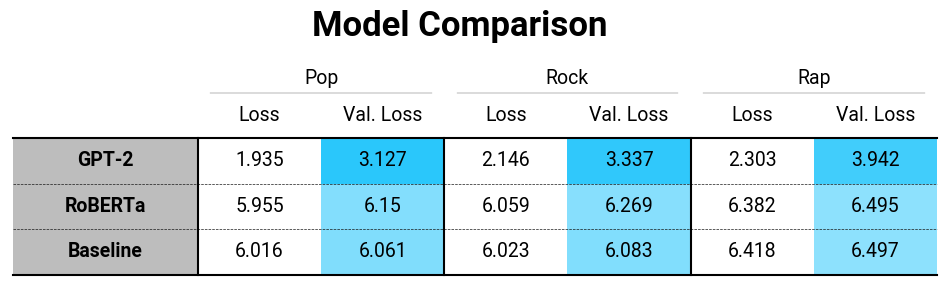

In [ ]:
# Creating a figure and axis
fig, ax = plt.subplots(figsize=(12, 3))

# Setting the face-colors of figure and axis
fig.set_facecolor('#ffffff')
ax.set_facecolor('#ffffff')

# Creating a custom colormap
customcmap1 = LinearSegmentedColormap.from_list('custom cmap', ['#02bcfa','#ffffff'])

# Using the table function to plot the table
col_defs = ([
                ColumnDefinition(name="Model",title="",textprops={"ha": "center","fontproperties":robotoBold},width=1.5,border="right"),
                
                ColumnDefinition(name="Pop Loss",title="Loss",textprops={"ha": "center"},width=1,group='Pop'),
                ColumnDefinition(name="Pop Val Loss",title="Val. Loss",textprops={"ha": "center"},width=1,border="right",group='Pop',
                                 cmap=normed_cmap(modelCompare["Pop Val Loss"], cmap=customcmap1, num_stds=2.5)),
                
                ColumnDefinition(name="Rock Loss",title="Loss",textprops={"ha": "center"},width=1,group='Rock'),
                ColumnDefinition(name="Rock Val Loss",title="Val. Loss",textprops={"ha": "center"},width=1,border="right",group='Rock',
                                 cmap=normed_cmap(modelCompare["Pop Val Loss"], cmap=customcmap1, num_stds=2.5)),
                
                ColumnDefinition(name="Rap Loss",title="Loss",textprops={"ha": "center"},width=1,group='Rap'),
                ColumnDefinition(name="Rap Val Loss",title="Val. Loss",textprops={"ha": "center"},width=1,group='Rap',
                                 cmap=normed_cmap(modelCompare["Pop Val Loss"], cmap=customcmap1, num_stds=2.5))
            ])

tab = Table(modelCompare,
            column_definitions=col_defs,
            row_dividers=True,
            footer_divider=True,
            ax=ax,
            textprops={"fontsize": 14,"fontproperties":robotoMed,'color':'k'},
            row_divider_kw={"linewidth": 0.5, "linestyle": '--','color':'#181818'},
            col_label_divider_kw={"linewidth": 1.5, "linestyle": "-",'color':'k'},
            column_border_kw={"linewidth": 1.5, "linestyle": "-",'color':'k'},
            footer_divider_kw={"linewidth": 1.5, "linestyle": "-",'color':'k'},
            )

tab.columns['Model'].set_facecolor('#bdbdbd')

# Adding the title for the figure 
fig.suptitle('Model Comparison',y=1,color='k',fontsize=25,fontweight='bold',fontproperties=robotoBold)

plt.show()

We are choosing GPT-2 as our best model since it has the lowest loss values compared to the baseline model and the RoBERTa model.

In [ ]:
pop_model = pop_gpt2_model
rock_model = rock_gpt2_model
rap_model = rap_gpt2_model

# **Fine-tuning Artist specific models**

Now that we have our GPT2 models for Pop, Rock and Rap, we can fine-tune them once more on the artists belonging to that genre.

In [ ]:
# Defining a function that will fine-tune genre model for a given artist

def finetune_model(model, artist_dataset, learning_rate = 1e-5):
  artist_model = createGPTModel(artist_dataset, model_checkpoint = "distilgpt2", learning_rate = learning_rate)[2]
  artist_model.set_weights(model.get_weights())
  data_train = artist_model.prepare_tf_dataset(artist_dataset['train'], shuffle = True, batch_size = 8)
  data_val = artist_model.prepare_tf_dataset(artist_dataset['test'], shuffle = True, batch_size = 8)
  return data_train, data_val, artist_model

## **Pop Artists**

In [ ]:
# File paths for Pop Artists
pop_artists_path = 'Data/Pop Artists/'
madonna_path = pop_artists_path + 'Madonna.csv'
mariahcarey_path = pop_artists_path + 'MariahCarey.csv'
mj_path = pop_artists_path + 'MichaelJackson.csv'
rihanna_path = pop_artists_path + 'Rihanna.csv'
taylorswift_path = pop_artists_path + 'TaylorSwift.csv'

# Obtaining the datasets for Pop Artists
madonna_ds = get_dataset(madonna_path)
mariahcarey_ds = get_dataset(mariahcarey_path)
mj_ds = get_dataset( mj_path)
rihanna_ds = get_dataset(rihanna_path)
taylorswift_ds = get_dataset(taylorswift_path)

# Building the dataset as required for language modelling for all Pop Artists
madonna_lmds = build_dataset(madonna_ds, tokenize_lyrics_gpt2)
mariahcarey_lmds = build_dataset(mariahcarey_ds, tokenize_lyrics_gpt2)
mj_lmds = build_dataset(mj_ds, tokenize_lyrics_gpt2)
rihanna_lmds = build_dataset(rihanna_ds, tokenize_lyrics_gpt2)
taylorswift_lmds = build_dataset(taylorswift_ds, tokenize_lyrics_gpt2)

clear_output()

### **Artist Model: Madonna**

In [ ]:
# Creating the Madonna model and the associated dataset
madonna_train, madonna_val, madonna_model = finetune_model(pop_model, madonna_lmds)

All model checkpoint layers were used when initializing TFGPT2LMHeadModel.

All the layers of TFGPT2LMHeadModel were initialized from the model checkpoint at distilgpt2.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2LMHeadModel for predictions without further training.
No loss specified in compile() - the model's internal loss computation will be used as the loss. Don't panic - this is a common way to train TensorFlow models in Transformers! To disable this behaviour please pass a loss argument, or explicitly pass `loss=None` if you do not want your model to compute a loss.


In [ ]:
# Fitting the Madonna model
history_madonna = madonna_model.fit(madonna_train, validation_data = madonna_val, epochs = 5)

Epoch 1/5
16/16 [==============================] - 20s 339ms/step - loss: 3.1870 - val_loss: 3.0513
Epoch 2/5
16/16 [==============================] - 3s 175ms/step - loss: 3.0682 - val_loss: 3.0001
Epoch 3/5
16/16 [==============================] - 3s 178ms/step - loss: 2.9845 - val_loss: 2.6474
Epoch 4/5
16/16 [==============================] - 3s 179ms/step - loss: 2.9274 - val_loss: 2.7016
Epoch 5/5
16/16 [==============================] - 3s 180ms/step - loss: 2.8576 - val_loss: 2.7401


### **Artist Model: Mariah Carey**

In [ ]:
# Creating the Mariah Carey model and the associated dataset
mariahcarey_train, mariahcarey_val, mariahcarey_model = finetune_model(pop_model, mariahcarey_lmds)

All model checkpoint layers were used when initializing TFGPT2LMHeadModel.

All the layers of TFGPT2LMHeadModel were initialized from the model checkpoint at distilgpt2.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2LMHeadModel for predictions without further training.
No loss specified in compile() - the model's internal loss computation will be used as the loss. Don't panic - this is a common way to train TensorFlow models in Transformers! To disable this behaviour please pass a loss argument, or explicitly pass `loss=None` if you do not want your model to compute a loss.


In [ ]:
# Fitting the Mariah Carey model
history_mariahcarey = mariahcarey_model.fit(mariahcarey_train, validation_data = mariahcarey_val, epochs = 5)

Epoch 1/5
14/14 [==============================] - 20s 354ms/step - loss: 3.2240 - val_loss: 3.0956
Epoch 2/5
14/14 [==============================] - 2s 171ms/step - loss: 3.1370 - val_loss: 3.2823
Epoch 3/5
14/14 [==============================] - 2s 172ms/step - loss: 3.0447 - val_loss: 2.9976
Epoch 4/5
14/14 [==============================] - 2s 173ms/step - loss: 3.0144 - val_loss: 3.2393
Epoch 5/5
14/14 [==============================] - 2s 174ms/step - loss: 2.9825 - val_loss: 3.0563


### **Artist Model: Michael Jackson**

In [ ]:
# Creating the Michael Jackson model and the associated dataset
mj_train, mj_val, mj_model = finetune_model(pop_model, mj_lmds)

All model checkpoint layers were used when initializing TFGPT2LMHeadModel.

All the layers of TFGPT2LMHeadModel were initialized from the model checkpoint at distilgpt2.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2LMHeadModel for predictions without further training.
No loss specified in compile() - the model's internal loss computation will be used as the loss. Don't panic - this is a common way to train TensorFlow models in Transformers! To disable this behaviour please pass a loss argument, or explicitly pass `loss=None` if you do not want your model to compute a loss.


In [ ]:
# Fitting the Michael Jackson model
history_mj = mj_model.fit(mj_train, validation_data = mj_val, epochs = 5)

Epoch 1/5
26/26 [==============================] - 22s 275ms/step - loss: 2.9756 - val_loss: 3.2946
Epoch 2/5
26/26 [==============================] - 5s 178ms/step - loss: 2.9014 - val_loss: 3.2636
Epoch 3/5
26/26 [==============================] - 5s 181ms/step - loss: 2.8173 - val_loss: 3.1950
Epoch 4/5
26/26 [==============================] - 5s 182ms/step - loss: 2.7515 - val_loss: 3.2514
Epoch 5/5
26/26 [==============================] - 5s 184ms/step - loss: 2.7096 - val_loss: 3.2432


### **Artist Model: Rihanna**

In [ ]:
# Creating the Rihanna model and the associated dataset
rihanna_train, rihanna_val, rihanna_model = finetune_model(pop_model, rihanna_lmds)

All model checkpoint layers were used when initializing TFGPT2LMHeadModel.

All the layers of TFGPT2LMHeadModel were initialized from the model checkpoint at distilgpt2.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2LMHeadModel for predictions without further training.
No loss specified in compile() - the model's internal loss computation will be used as the loss. Don't panic - this is a common way to train TensorFlow models in Transformers! To disable this behaviour please pass a loss argument, or explicitly pass `loss=None` if you do not want your model to compute a loss.


In [ ]:
# Fitting the Rihanna model
history_rihanna = rihanna_model.fit(rihanna_train, validation_data = rihanna_val, epochs = 5)

Epoch 1/5
21/21 [==============================] - 22s 295ms/step - loss: 2.9641 - val_loss: 1.7454
Epoch 2/5
21/21 [==============================] - 4s 174ms/step - loss: 2.8488 - val_loss: 1.7326
Epoch 3/5
21/21 [==============================] - 4s 177ms/step - loss: 2.8249 - val_loss: 1.7273
Epoch 4/5
21/21 [==============================] - 4s 178ms/step - loss: 2.7849 - val_loss: 1.7250
Epoch 5/5
21/21 [==============================] - 4s 179ms/step - loss: 2.7484 - val_loss: 1.7233


### **Artist Model: Taylor Swift**

In [ ]:
# Creating the Taylor Swift model and the associated dataset
taylorswift_train, taylorswift_val, taylorswift_model = finetune_model(pop_model, taylorswift_lmds)

All model checkpoint layers were used when initializing TFGPT2LMHeadModel.

All the layers of TFGPT2LMHeadModel were initialized from the model checkpoint at distilgpt2.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2LMHeadModel for predictions without further training.
No loss specified in compile() - the model's internal loss computation will be used as the loss. Don't panic - this is a common way to train TensorFlow models in Transformers! To disable this behaviour please pass a loss argument, or explicitly pass `loss=None` if you do not want your model to compute a loss.


In [ ]:
# Fitting the Taylor Swift model
history_taylorswift = taylorswift_model.fit(taylorswift_train, validation_data = taylorswift_val, epochs = 5)

Epoch 1/5
31/31 [==============================] - 23s 264ms/step - loss: 3.9135 - val_loss: 4.1543
Epoch 2/5
31/31 [==============================] - 6s 185ms/step - loss: 3.7607 - val_loss: 4.0442
Epoch 3/5
31/31 [==============================] - 6s 188ms/step - loss: 3.6724 - val_loss: 3.9893
Epoch 4/5
31/31 [==============================] - 6s 186ms/step - loss: 3.6085 - val_loss: 3.9746
Epoch 5/5
31/31 [==============================] - 6s 186ms/step - loss: 3.5718 - val_loss: 3.9200


## **Rock Artists**

In [ ]:
# File paths for Rock Artists
rock_artists_path = 'Data/Rock Artists/'
hallandoates_path = rock_artists_path + 'HallAndOates.csv'
imaginedragons_path = rock_artists_path + 'ImagineDragons.csv'
neildiamond_path = rock_artists_path + 'NeilDiamond.csv'
rollingstones_path = rock_artists_path + 'RollingStones.csv'
beatles_path = rock_artists_path + 'TheBeatles.csv'

# Obtaining the datasets for Rock Artists
hallandoates_ds = get_dataset(hallandoates_path)
imaginedragons_ds = get_dataset(imaginedragons_path)
neildiamond_ds = get_dataset(neildiamond_path)
rollingstones_ds = get_dataset(rollingstones_path)
beatles_ds = get_dataset(beatles_path)

# Building the dataset as required for language modelling for all Rock Artists
hallandoates_lmds = build_dataset(hallandoates_ds, tokenize_lyrics_gpt2)
imaginedragons_lmds = build_dataset(imaginedragons_ds, tokenize_lyrics_gpt2)
neildiamond_lmds = build_dataset(neildiamond_ds, tokenize_lyrics_gpt2)
rollingstones_lmds = build_dataset(rollingstones_ds, tokenize_lyrics_gpt2)
beatles_lmds = build_dataset(beatles_ds, tokenize_lyrics_gpt2)

clear_output()

### **Artist Model: Daryl Hall and John Oates**

In [ ]:
# Creating the Daryl Hall and John Oates model and the associated dataset
hao_train, hao_val, hao_model = finetune_model(rock_model, hallandoates_lmds, learning_rate = 1e-5)

All model checkpoint layers were used when initializing TFGPT2LMHeadModel.

All the layers of TFGPT2LMHeadModel were initialized from the model checkpoint at distilgpt2.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2LMHeadModel for predictions without further training.
No loss specified in compile() - the model's internal loss computation will be used as the loss. Don't panic - this is a common way to train TensorFlow models in Transformers! To disable this behaviour please pass a loss argument, or explicitly pass `loss=None` if you do not want your model to compute a loss.


In [ ]:
# Fitting the Daryl Hall and John Oates model
history_hallandoates = hao_model.fit(hao_train, validation_data = hao_val, epochs = 5)

Epoch 1/5
10/10 [==============================] - 20s 462ms/step - loss: 3.0953 - val_loss: 2.6415
Epoch 2/5
10/10 [==============================] - 2s 194ms/step - loss: 2.9919 - val_loss: 2.5066
Epoch 3/5
10/10 [==============================] - 2s 197ms/step - loss: 2.9816 - val_loss: 2.7170
Epoch 4/5
10/10 [==============================] - 2s 199ms/step - loss: 2.9231 - val_loss: 2.5382
Epoch 5/5
10/10 [==============================] - 2s 202ms/step - loss: 2.8757 - val_loss: 2.2629


### **Artist Model: Imagine Dragons**

In [ ]:
# Creating the Imagine Dragons model and the associated dataset
imgd_train, imgd_val, imgd_model = finetune_model(rock_model, imaginedragons_lmds, learning_rate = 2e-5)

All model checkpoint layers were used when initializing TFGPT2LMHeadModel.

All the layers of TFGPT2LMHeadModel were initialized from the model checkpoint at distilgpt2.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2LMHeadModel for predictions without further training.
No loss specified in compile() - the model's internal loss computation will be used as the loss. Don't panic - this is a common way to train TensorFlow models in Transformers! To disable this behaviour please pass a loss argument, or explicitly pass `loss=None` if you do not want your model to compute a loss.


In [ ]:
# Fitting the Imagine Dragons model
history_imgd = imgd_model.fit(imgd_train, validation_data = imgd_val, epochs = 5)

Epoch 1/5
13/13 [==============================] - 21s 403ms/step - loss: 3.3454 - val_loss: 3.3205
Epoch 2/5
13/13 [==============================] - 3s 201ms/step - loss: 3.1525 - val_loss: 3.2321
Epoch 3/5
13/13 [==============================] - 3s 204ms/step - loss: 3.0849 - val_loss: 3.2178
Epoch 4/5
13/13 [==============================] - 3s 206ms/step - loss: 2.9712 - val_loss: 3.1908
Epoch 5/5
13/13 [==============================] - 3s 209ms/step - loss: 2.9634 - val_loss: 3.1369


### **Artist Model: Neil Diamond**

In [ ]:
# Creating the Neil Diamond model and the associated dataset
neild_train, neild_val, neild_model = finetune_model(rock_model, neildiamond_lmds, learning_rate = 1e-5)

All model checkpoint layers were used when initializing TFGPT2LMHeadModel.

All the layers of TFGPT2LMHeadModel were initialized from the model checkpoint at distilgpt2.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2LMHeadModel for predictions without further training.
No loss specified in compile() - the model's internal loss computation will be used as the loss. Don't panic - this is a common way to train TensorFlow models in Transformers! To disable this behaviour please pass a loss argument, or explicitly pass `loss=None` if you do not want your model to compute a loss.


In [ ]:
# Fitting the Neil Diamond model
history_neild = neild_model.fit(neild_train, validation_data = neild_val, epochs = 5)

Epoch 1/5
7/7 [==============================] - 20s 617ms/step - loss: 3.8139 - val_loss: 3.9465
Epoch 2/5
7/7 [==============================] - 1s 196ms/step - loss: 3.6446 - val_loss: 4.1531
Epoch 3/5
7/7 [==============================] - 1s 200ms/step - loss: 3.5948 - val_loss: 3.2499
Epoch 4/5
7/7 [==============================] - 1s 203ms/step - loss: 3.4780 - val_loss: 3.5390
Epoch 5/5
7/7 [==============================] - 1s 202ms/step - loss: 3.5678 - val_loss: 3.4831


### **Artist Model: Rolling Stones**

In [ ]:
# Creating the Rolling Stones model and the associated dataset
rolst_train, rolst_val, rolst_model = finetune_model(rock_model, rollingstones_lmds, learning_rate = 1e-4)

All model checkpoint layers were used when initializing TFGPT2LMHeadModel.

All the layers of TFGPT2LMHeadModel were initialized from the model checkpoint at distilgpt2.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2LMHeadModel for predictions without further training.
No loss specified in compile() - the model's internal loss computation will be used as the loss. Don't panic - this is a common way to train TensorFlow models in Transformers! To disable this behaviour please pass a loss argument, or explicitly pass `loss=None` if you do not want your model to compute a loss.


In [ ]:
# Fitting the Rolling Stones model
history_rolst = rolst_model.fit(rolst_train, validation_data = rolst_val, epochs = 5)

Epoch 1/5
11/11 [==============================] - 20s 441ms/step - loss: 3.3288 - val_loss: 3.3305
Epoch 2/5
11/11 [==============================] - 2s 200ms/step - loss: 3.0311 - val_loss: 3.3071
Epoch 3/5
11/11 [==============================] - 2s 203ms/step - loss: 2.7829 - val_loss: 3.2575
Epoch 4/5
11/11 [==============================] - 2s 206ms/step - loss: 2.6063 - val_loss: 3.0682
Epoch 5/5
11/11 [==============================] - 2s 209ms/step - loss: 2.4304 - val_loss: 3.2279


### **Artist Model: The Beatles**

In [ ]:
# Creating the The Beatles model and the associated dataset
tbeat_train, tbeat_val, tbeat_model = finetune_model(rock_model, beatles_lmds, learning_rate = 1e-7)

All model checkpoint layers were used when initializing TFGPT2LMHeadModel.

All the layers of TFGPT2LMHeadModel were initialized from the model checkpoint at distilgpt2.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2LMHeadModel for predictions without further training.
No loss specified in compile() - the model's internal loss computation will be used as the loss. Don't panic - this is a common way to train TensorFlow models in Transformers! To disable this behaviour please pass a loss argument, or explicitly pass `loss=None` if you do not want your model to compute a loss.


In [ ]:
# Fitting the The Beatles model
history_tbeat = tbeat_model.fit(tbeat_train, validation_data = tbeat_val, epochs = 5)

Epoch 1/5
7/7 [==============================] - 19s 595ms/step - loss: 3.1842 - val_loss: 3.3781
Epoch 2/5
7/7 [==============================] - 1s 191ms/step - loss: 3.1532 - val_loss: 2.6589
Epoch 3/5
7/7 [==============================] - 1s 193ms/step - loss: 3.0444 - val_loss: 2.1285
Epoch 4/5
7/7 [==============================] - 1s 197ms/step - loss: 3.0753 - val_loss: 2.1443
Epoch 5/5
7/7 [==============================] - 1s 196ms/step - loss: 3.1671 - val_loss: 1.8907


## **Rap Artists**

In [ ]:
# File paths for Rap Artists
rap_artists_path = 'Data/Rap Artists/'
drake_path = rap_artists_path + 'Drake.csv'
eminem_path = rap_artists_path + 'Eminem.csv'
kanye_path = rap_artists_path + 'KanyeWest.csv'
lilwayne_path = rap_artists_path + 'LilWayne.csv'
nicki_path = rap_artists_path + 'NickiMinaj.csv'

# Obtaining the datasets for Rap Artists
drake_ds = get_dataset(drake_path)
eminem_ds = get_dataset(eminem_path)
kanye_ds = get_dataset(kanye_path)
lilwayne_ds = get_dataset(lilwayne_path)
nicki_ds = get_dataset(nicki_path)

# Building the dataset as required for language modelling for all Rap Artists
drake_lmds = build_dataset(drake_ds, tokenize_lyrics_gpt2)
eminem_lmds = build_dataset(eminem_ds, tokenize_lyrics_gpt2)
kanye_lmds = build_dataset(kanye_ds, tokenize_lyrics_gpt2)
lilwayne_lmds = build_dataset(lilwayne_ds, tokenize_lyrics_gpt2)
nicki_lmds = build_dataset(nicki_ds, tokenize_lyrics_gpt2)

clear_output()

### **Artist Model: Drake**

In [ ]:
# Creating the Drake model and the associated dataset
drake_train, drake_val, drake_model = finetune_model(rap_model, drake_lmds, learning_rate = 1e-6)

All model checkpoint layers were used when initializing TFGPT2LMHeadModel.

All the layers of TFGPT2LMHeadModel were initialized from the model checkpoint at distilgpt2.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2LMHeadModel for predictions without further training.
No loss specified in compile() - the model's internal loss computation will be used as the loss. Don't panic - this is a common way to train TensorFlow models in Transformers! To disable this behaviour please pass a loss argument, or explicitly pass `loss=None` if you do not want your model to compute a loss.


In [ ]:
# Fitting the Drake model
history_drake = drake_model.fit(drake_train, validation_data = drake_val, epochs = 10)

Epoch 1/10
40/40 [==============================] - 25s 249ms/step - loss: 4.0078 - val_loss: 4.1389
Epoch 2/10
40/40 [==============================] - 8s 192ms/step - loss: 3.9835 - val_loss: 4.1389
Epoch 3/10
40/40 [==============================] - 8s 197ms/step - loss: 3.9708 - val_loss: 4.0433
Epoch 4/10
40/40 [==============================] - 8s 204ms/step - loss: 3.9486 - val_loss: 4.0962
Epoch 5/10
40/40 [==============================] - 8s 206ms/step - loss: 3.9433 - val_loss: 4.0333
Epoch 6/10
40/40 [==============================] - 8s 200ms/step - loss: 3.9079 - val_loss: 4.0471
Epoch 7/10
40/40 [==============================] - 8s 195ms/step - loss: 3.8801 - val_loss: 4.0244
Epoch 8/10
40/40 [==============================] - 8s 193ms/step - loss: 3.8811 - val_loss: 3.9716
Epoch 9/10
40/40 [==============================] - 8s 190ms/step - loss: 3.8662 - val_loss: 4.0534
Epoch 10/10
40/40 [==============================] - 8s 189ms/step - loss: 3.8527 - val_loss: 4.040

### **Artist Model: Eminem**

In [ ]:
# Creating the Eminem model and the associated dataset
eminem_train, eminem_val, eminem_model = finetune_model(rap_model, eminem_lmds)

All model checkpoint layers were used when initializing TFGPT2LMHeadModel.

All the layers of TFGPT2LMHeadModel were initialized from the model checkpoint at distilgpt2.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2LMHeadModel for predictions without further training.
No loss specified in compile() - the model's internal loss computation will be used as the loss. Don't panic - this is a common way to train TensorFlow models in Transformers! To disable this behaviour please pass a loss argument, or explicitly pass `loss=None` if you do not want your model to compute a loss.


In [ ]:
# Fitting the Eminem model
history_eminem = eminem_model.fit(eminem_train, validation_data = eminem_val, epochs = 10)

Epoch 1/10
46/46 [==============================] - 26s 245ms/step - loss: 4.7192 - val_loss: 4.4506
Epoch 2/10
46/46 [==============================] - 9s 196ms/step - loss: 4.5543 - val_loss: 4.4150
Epoch 3/10
46/46 [==============================] - 9s 205ms/step - loss: 4.4996 - val_loss: 4.3594
Epoch 4/10
46/46 [==============================] - 10s 210ms/step - loss: 4.4324 - val_loss: 4.3581
Epoch 5/10
46/46 [==============================] - 9s 205ms/step - loss: 4.4102 - val_loss: 4.3108
Epoch 6/10
46/46 [==============================] - 9s 198ms/step - loss: 4.3580 - val_loss: 4.3125
Epoch 7/10
46/46 [==============================] - 9s 194ms/step - loss: 4.3239 - val_loss: 4.2783
Epoch 8/10
46/46 [==============================] - 9s 192ms/step - loss: 4.2922 - val_loss: 4.3008
Epoch 9/10
46/46 [==============================] - 9s 191ms/step - loss: 4.2633 - val_loss: 4.2696
Epoch 10/10
46/46 [==============================] - 9s 193ms/step - loss: 4.2357 - val_loss: 4.27

### **Artist Model: Kanye West**

In [ ]:
# Creating the Kanye West model and the associated dataset
kanye_train, kanye_val, kanye_model = finetune_model(rap_model, kanye_lmds)

All model checkpoint layers were used when initializing TFGPT2LMHeadModel.

All the layers of TFGPT2LMHeadModel were initialized from the model checkpoint at distilgpt2.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2LMHeadModel for predictions without further training.
No loss specified in compile() - the model's internal loss computation will be used as the loss. Don't panic - this is a common way to train TensorFlow models in Transformers! To disable this behaviour please pass a loss argument, or explicitly pass `loss=None` if you do not want your model to compute a loss.


In [ ]:
# Fitting the Kanye West model
history_kanye = kanye_model.fit(kanye_train, validation_data = kanye_val, epochs = 10)

Epoch 1/10
23/23 [==============================] - 22s 297ms/step - loss: 4.5305 - val_loss: 4.0436
Epoch 2/10
23/23 [==============================] - 4s 191ms/step - loss: 4.3863 - val_loss: 3.9152
Epoch 3/10
23/23 [==============================] - 4s 195ms/step - loss: 4.3052 - val_loss: 3.8754
Epoch 4/10
23/23 [==============================] - 5s 198ms/step - loss: 4.2484 - val_loss: 3.9599
Epoch 5/10
23/23 [==============================] - 5s 200ms/step - loss: 4.1946 - val_loss: 3.8820
Epoch 6/10
23/23 [==============================] - 5s 206ms/step - loss: 4.1609 - val_loss: 3.8919
Epoch 7/10
23/23 [==============================] - 5s 208ms/step - loss: 4.1259 - val_loss: 3.8076
Epoch 8/10
23/23 [==============================] - 5s 210ms/step - loss: 4.0962 - val_loss: 3.9032
Epoch 9/10
23/23 [==============================] - 5s 209ms/step - loss: 4.0553 - val_loss: 3.8052
Epoch 10/10
23/23 [==============================] - 5s 206ms/step - loss: 4.0230 - val_loss: 3.866

### **Artist Model: Lil Wayne**

In [ ]:
# Creating the Lil Wayne model and the associated dataset
wayne_train, wayne_val, wayne_model = finetune_model(rap_model, lilwayne_lmds)

All model checkpoint layers were used when initializing TFGPT2LMHeadModel.

All the layers of TFGPT2LMHeadModel were initialized from the model checkpoint at distilgpt2.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2LMHeadModel for predictions without further training.
No loss specified in compile() - the model's internal loss computation will be used as the loss. Don't panic - this is a common way to train TensorFlow models in Transformers! To disable this behaviour please pass a loss argument, or explicitly pass `loss=None` if you do not want your model to compute a loss.


In [ ]:
# Fitting the Lil Wayne model
history_wayne = wayne_model.fit(wayne_train, validation_data = wayne_val, epochs = 10)

Epoch 1/10
35/35 [==============================] - 25s 259ms/step - loss: 4.2731 - val_loss: 4.7227
Epoch 2/10
35/35 [==============================] - 7s 191ms/step - loss: 4.1096 - val_loss: 4.6821
Epoch 3/10
35/35 [==============================] - 7s 197ms/step - loss: 4.0578 - val_loss: 4.5894
Epoch 4/10
35/35 [==============================] - 7s 203ms/step - loss: 3.9952 - val_loss: 4.5566
Epoch 5/10
35/35 [==============================] - 7s 208ms/step - loss: 3.9514 - val_loss: 4.5199
Epoch 6/10
35/35 [==============================] - 7s 205ms/step - loss: 3.9071 - val_loss: 4.6322
Epoch 7/10
35/35 [==============================] - 7s 200ms/step - loss: 3.8740 - val_loss: 4.5855
Epoch 8/10
35/35 [==============================] - 7s 197ms/step - loss: 3.8491 - val_loss: 4.5936
Epoch 9/10
35/35 [==============================] - 7s 193ms/step - loss: 3.8083 - val_loss: 4.4725
Epoch 10/10
35/35 [==============================] - 7s 191ms/step - loss: 3.7835 - val_loss: 4.545

### **Artist Model: Nicki Minaj**

In [ ]:
# Creating the Nicki Minaj model and the associated dataset
nicki_train, nicki_val, nicki_model = finetune_model(rap_model, nicki_lmds)

All model checkpoint layers were used when initializing TFGPT2LMHeadModel.

All the layers of TFGPT2LMHeadModel were initialized from the model checkpoint at distilgpt2.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2LMHeadModel for predictions without further training.
No loss specified in compile() - the model's internal loss computation will be used as the loss. Don't panic - this is a common way to train TensorFlow models in Transformers! To disable this behaviour please pass a loss argument, or explicitly pass `loss=None` if you do not want your model to compute a loss.


In [ ]:
# Fitting the Nicki Minaj model
history_nicki = nicki_model.fit(nicki_train, validation_data = nicki_val, epochs = 10)

Epoch 1/10
28/28 [==============================] - 24s 304ms/step - loss: 4.0577 - val_loss: 3.7726
Epoch 2/10
28/28 [==============================] - 5s 189ms/step - loss: 3.9118 - val_loss: 3.6273
Epoch 3/10
28/28 [==============================] - 5s 192ms/step - loss: 3.8150 - val_loss: 3.6372
Epoch 4/10
28/28 [==============================] - 5s 190ms/step - loss: 3.7773 - val_loss: 3.5987
Epoch 5/10
28/28 [==============================] - 5s 189ms/step - loss: 3.7168 - val_loss: 3.6174
Epoch 6/10
28/28 [==============================] - 5s 191ms/step - loss: 3.6670 - val_loss: 3.5960
Epoch 7/10
28/28 [==============================] - 6s 198ms/step - loss: 3.6261 - val_loss: 3.6359
Epoch 8/10
28/28 [==============================] - 5s 193ms/step - loss: 3.6075 - val_loss: 3.5831
Epoch 9/10
28/28 [==============================] - 5s 195ms/step - loss: 3.5662 - val_loss: 3.5928
Epoch 10/10
28/28 [==============================] - 5s 194ms/step - loss: 3.5265 - val_loss: 3.591

# **Writing Pop Songs**

Using text generation pipeline from the transformers library, we'll create a `song_writer` function that will generate lyrics given an input prompt, maximum length of the generated text and model to be used for generation.

In [ ]:
def song_writer(input_prompt, song_length, model):
  text_generator = pipeline('text-generation', tokenizer = tokenize_lyrics_gpt2, model = model, framework = 'tf')
  song = text_generator(input_prompt, max_length = song_length)[0]['generated_text']
  clear_output()
  return song

In [ ]:
# Function to display the generated song
def displaySong(song):

    song = '\n'.join(song.split('\n')[:20])

    fig,ax = plt.subplots(figsize=(7,10))
    plt.subplots_adjust(wspace=0.3)

    fig.set_facecolor('#2b2b2b')
    ax.set_facecolor('#2b2b2b')

    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    for spine in ['right','top','bottom','left']:
        ax.spines[spine].set_visible(False)
    ax.set_xlim(0,100)
    ax.set_ylim(0,100)

    ax.text(50,50,'\n'+song+'\n',
                fontsize=14,c='w',
                ha='center',va='center',linespacing=2,
                bbox=dict(facecolor='None',alpha=1,boxstyle=('round,rounding_size=0.8'),linewidth=3,edgecolor='#bdbdbd'))


    fig.suptitle('AI Generated Song',x=.5, y=0.915,ha='center',va='center',fontsize = 25, fontweight='bold',color = 'white')
    plt.show()

## **Songs generated by: Pop Model**

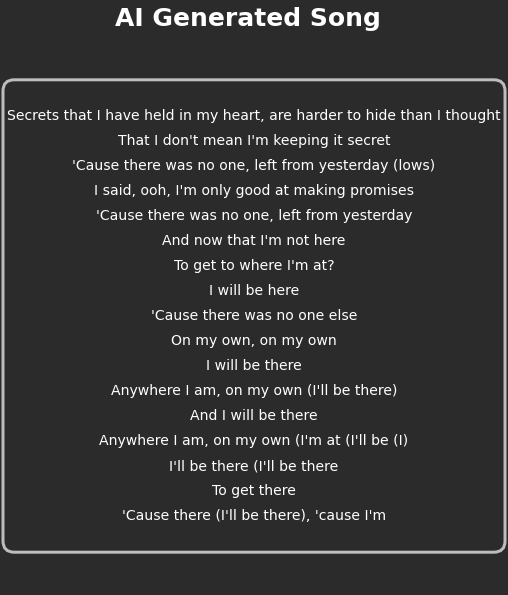

In [ ]:
pop_prompt1 = "Secrets that I have held in my heart, are harder to hide than I thought"
pop_gen_song1 = song_writer(pop_prompt1, 180, pop_model)
displaySong(pop_gen_song1)

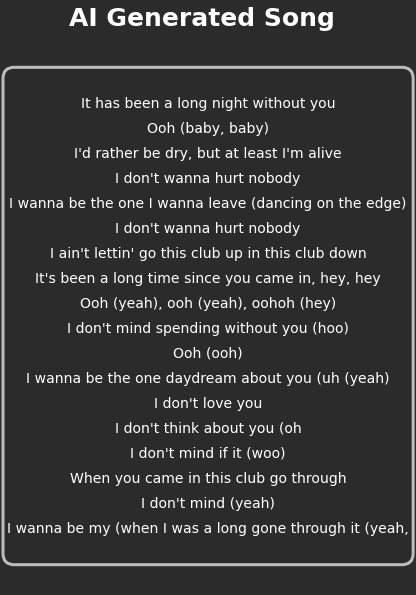

In [ ]:
pop_prompt2 = "It has been a long night"
pop_gen_song2 = song_writer(pop_prompt2, 200, pop_model)
displaySong(pop_gen_song2)

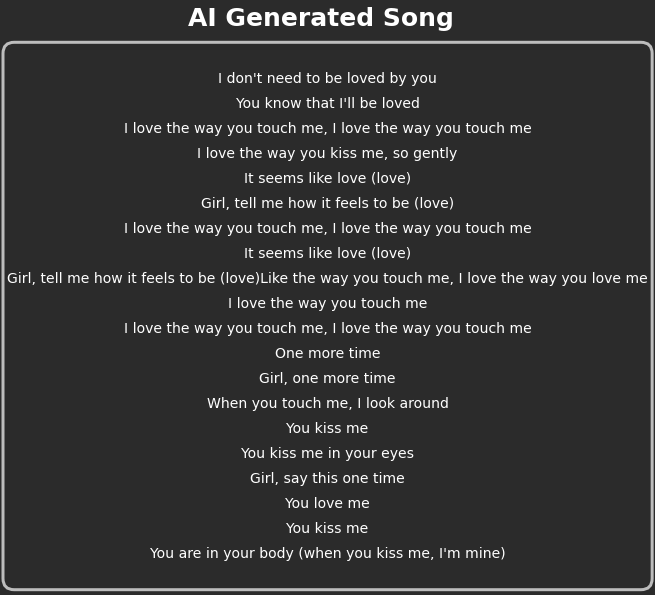

In [ ]:
pop_prompt3 = "I don't need to be loved by you"
pop_gen_song3 = song_writer(pop_prompt3, 250, pop_model)
displaySong(pop_gen_song3)

## **Songs generated by: Madonna Model**

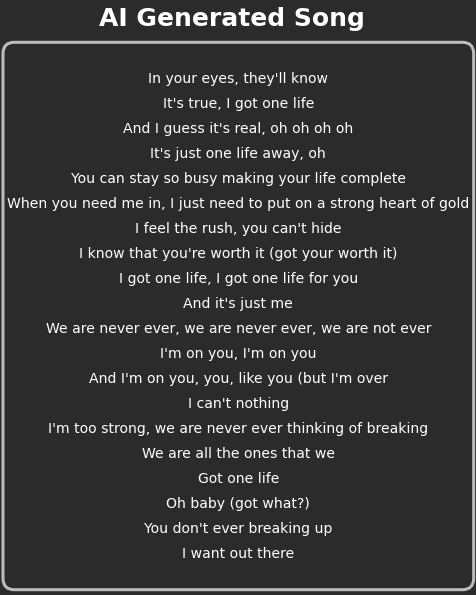

In [ ]:
madonna_prompt1 = "In your eyes"
madonna_gen_song1 = song_writer(madonna_prompt1, 200, madonna_model)
displaySong(madonna_gen_song1)

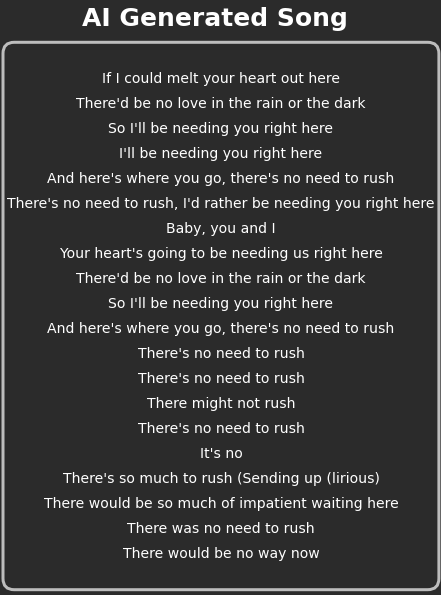

In [ ]:
madonna_prompt2 = "If I could melt your heart"
madonna_gen_song2 = song_writer(madonna_prompt2, 200, madonna_model)
displaySong(madonna_gen_song2)

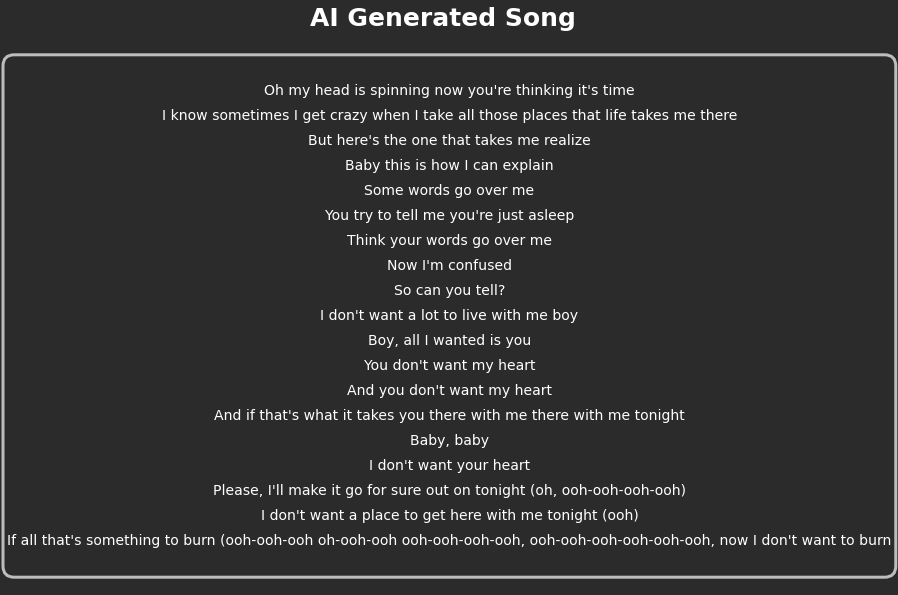

In [ ]:
madonna_prompt3 = "Oh my head is spinning now"
madonna_gen_song3 = song_writer(madonna_prompt3, 250, madonna_model)
displaySong(madonna_gen_song3)

## **Songs generated by: Mariah Carey Model**

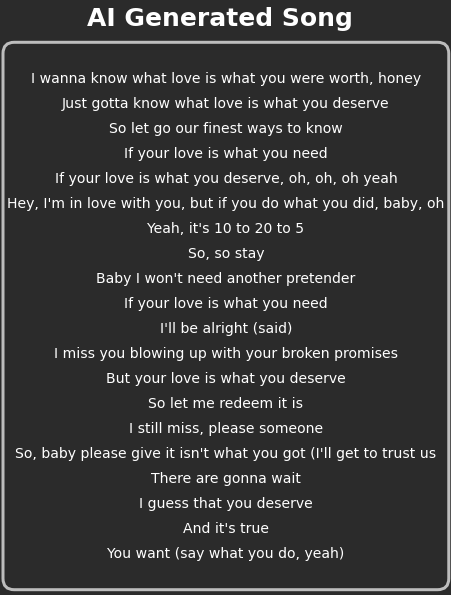

In [ ]:
mariahcarey_prompt1 = "I wanna know what love is"
mariahcarey_gen_song1 = song_writer(mariahcarey_prompt1, 250, mariahcarey_model)
displaySong(mariahcarey_gen_song1)

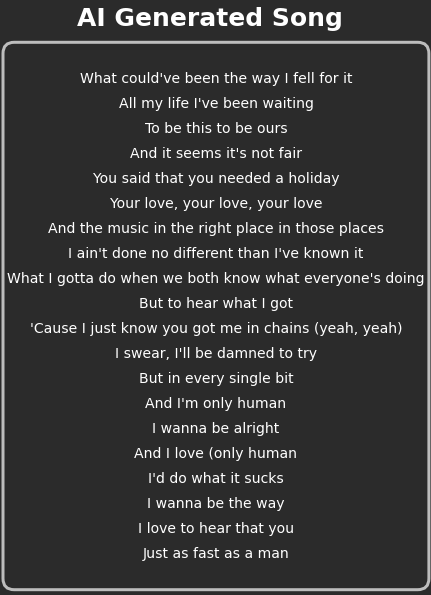

In [ ]:
mariahcarey_prompt2 = "What could've been"
mariahcarey_gen_song2 = song_writer(mariahcarey_prompt2, 220, mariahcarey_model)
displaySong(mariahcarey_gen_song2)

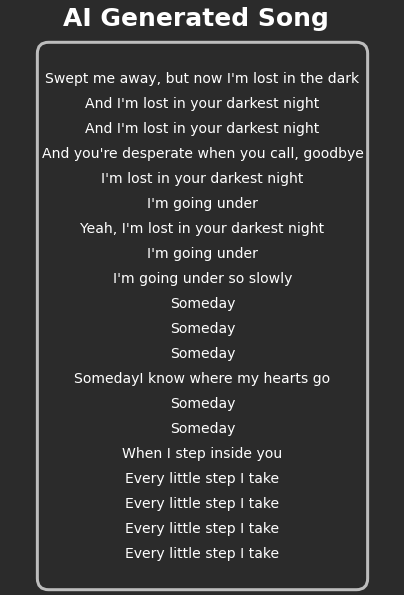

In [ ]:
mariahcarey_prompt3 = "Swept me away, but now I'm lost in the dark"
mariahcarey_gen_song3 = song_writer(mariahcarey_prompt3, 200, mariahcarey_model)
displaySong(mariahcarey_gen_song3)

## **Songs generated by: Michael Jackson Model**

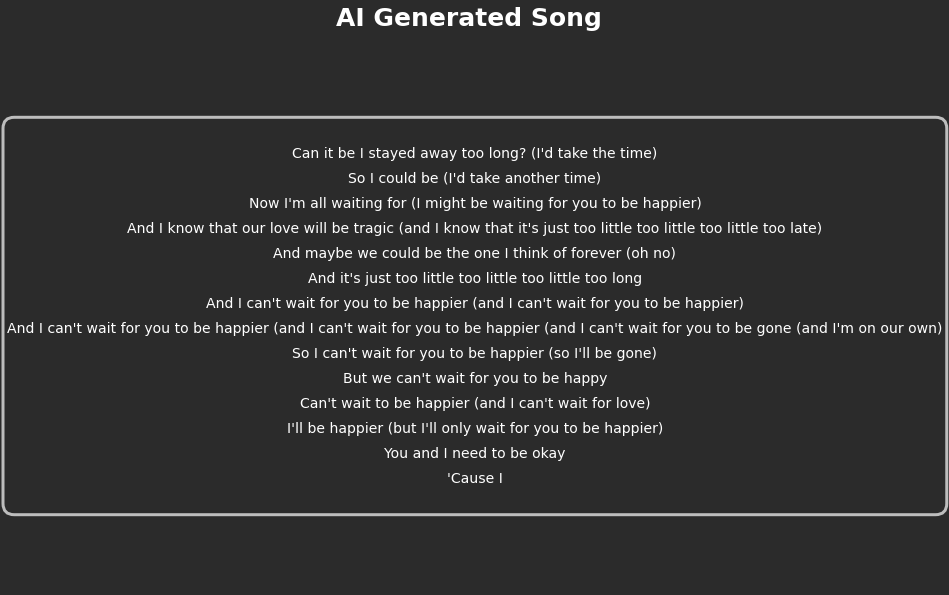

In [ ]:
mj_prompt1 = "Can it be I stayed away too long?"
mj_gen_song1 = song_writer(mj_prompt1, 240, mj_model)
displaySong(mj_gen_song1)

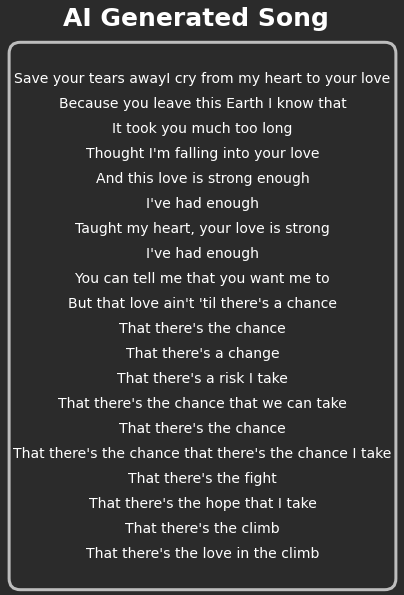

In [ ]:
mj_prompt2 = "Save your tears"
mj_gen_song2 = song_writer(mj_prompt2, 220, mj_model)
displaySong(mj_gen_song2)

In [ ]:
mj_prompt3 = "This love is taking a toll on me"
mj_gen_song3 = song_writer(mj_prompt3, 200, mj_model)
displaySong(mj_gen_song3)

## **Songs generated by: Rihanna Model**

In [ ]:
rihanna_prompt1 = "I am a prisoner"
rihanna_gen_song1 = song_writer(rihanna_prompt1, 200, rihanna_model)
displaySong(rihanna_gen_song1)

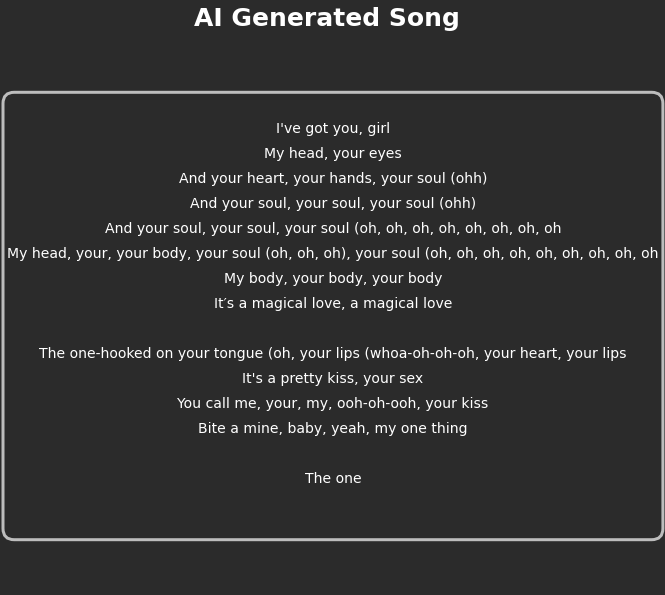

In [ ]:
rihanna_prompt2 = "I've got you"
rihanna_gen_song2 = song_writer(rihanna_prompt2, 200, rihanna_model)
displaySong(rihanna_gen_song2)

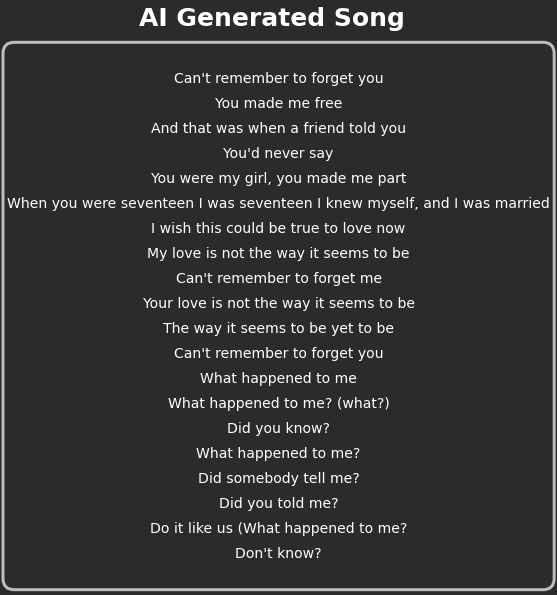

In [ ]:
rihanna_prompt3 = "Can't remember to forget you"
rihanna_gen_song3 = song_writer(rihanna_prompt3, 200, rihanna_model)
displaySong(rihanna_gen_song3)

## **Songs generated by: Taylor Swift Model**

In [ ]:
taylorswift_prompt1 = "There I was again tonight\nForcing laughter, faking smiles\nSame old tired, lonely place"
taylorswift_gen_song1 = song_writer(taylorswift_prompt1, 240, taylorswift_model)
displaySong(taylorswift_gen_song1)

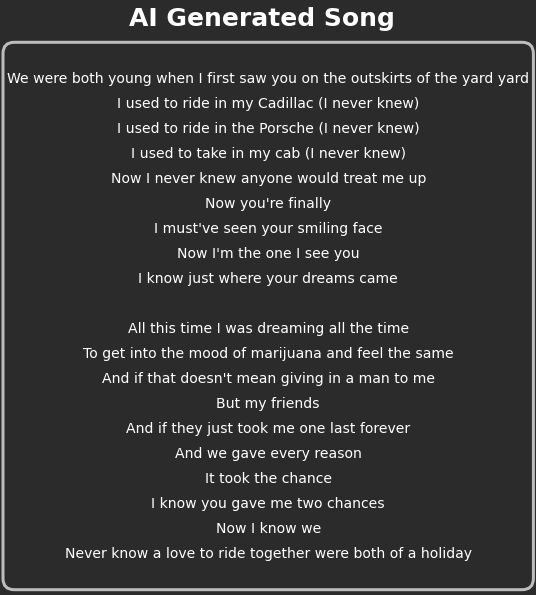

In [ ]:
taylorswift_prompt2 = "We were both young when I first saw you"
taylorswift_gen_song2 = song_writer(taylorswift_prompt2, 200, taylorswift_model)
displaySong(taylorswift_gen_song2)

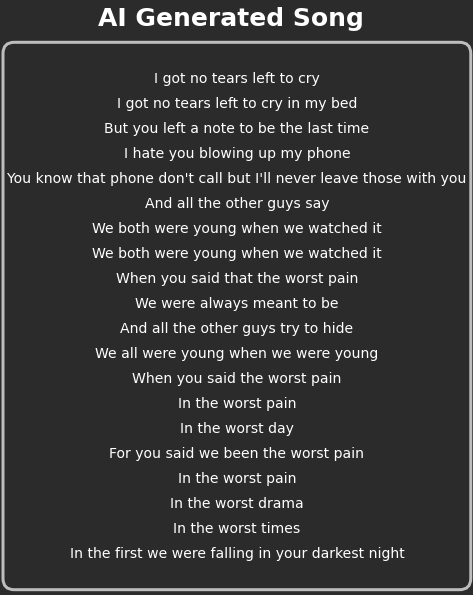

In [ ]:
taylorswift_prompt3 = "I got no tears left to cry"
taylorswift_gen_song3 = song_writer(taylorswift_prompt3, 200, taylorswift_model)
displaySong(taylorswift_gen_song3)

# **Writing Rock Songs**

## **Songs generated by: Rock Model**

In [ ]:
rock_prompt1 = "Take what you want from me"
rock_song1 = song_writer(rock_prompt1, 180, rock_model)
displaySong(rock_song1)

In [ ]:
rock_prompt2 = "I would be nothing"
rock_song2 = song_writer(rock_prompt2, 200, rock_model)
displaySong(rock_song2)

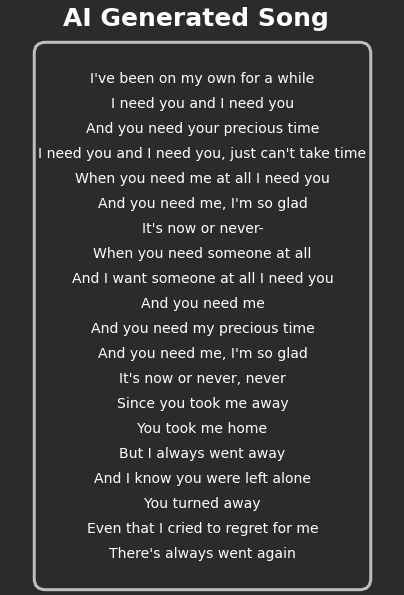

In [ ]:
rock_prompt3 = "I've been on my own for a while"
rock_song3 = song_writer(rock_prompt3, 200, rock_model)
displaySong(rock_song3)

## **Songs generated by: Daryl Hall and John Oates Model**

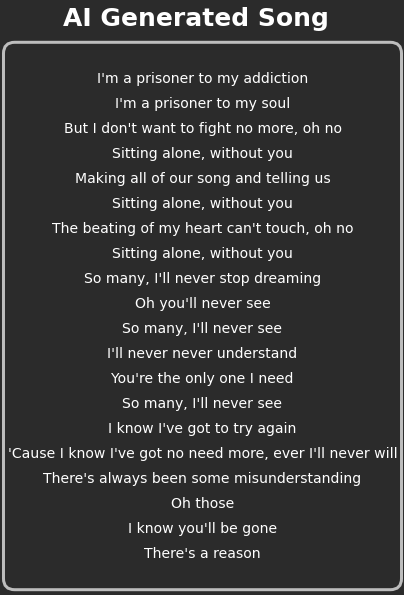

In [ ]:
hao_prompt1 = "I'm a prisoner to my addiction"
hao_gen_song1 = song_writer(hao_prompt1, 200, hao_model)
displaySong(hao_gen_song1)

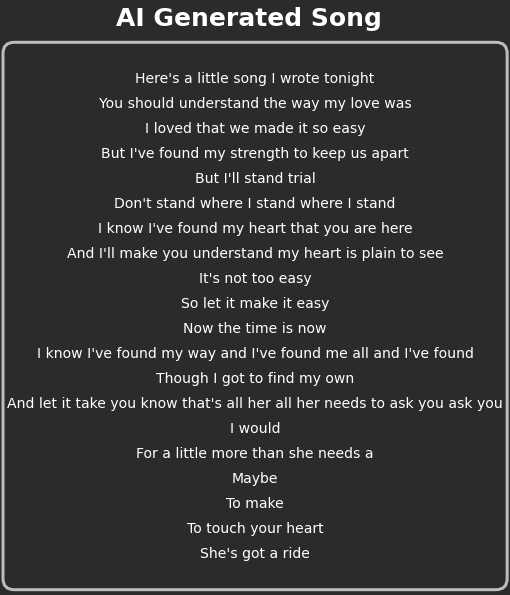

In [ ]:
hao_prompt2 = "Here's a little song I wrote"
hao_gen_song2 = song_writer(hao_prompt2, 180, hao_model)
displaySong(hao_gen_song2)

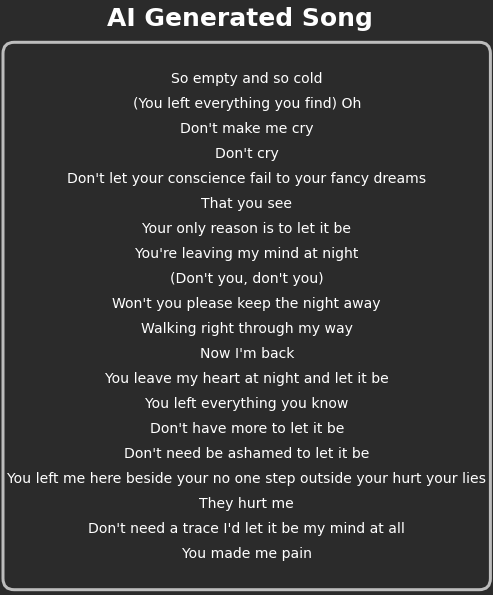

In [ ]:
hao_prompt3 = "So empty and so cold"
hao_gen_song3 = song_writer(hao_prompt3, 180, hao_model)
displaySong(hao_gen_song3)

## **Songs generated by: Imagine Dragons Model**

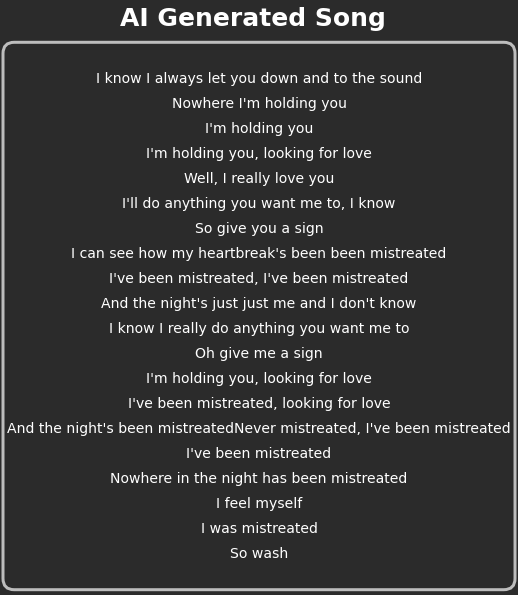

In [ ]:
imgd_prompt1 = "I know I always let you down"
imgd_gen_song1 = song_writer(imgd_prompt1, 200, imgd_model)
displaySong(imgd_gen_song1)

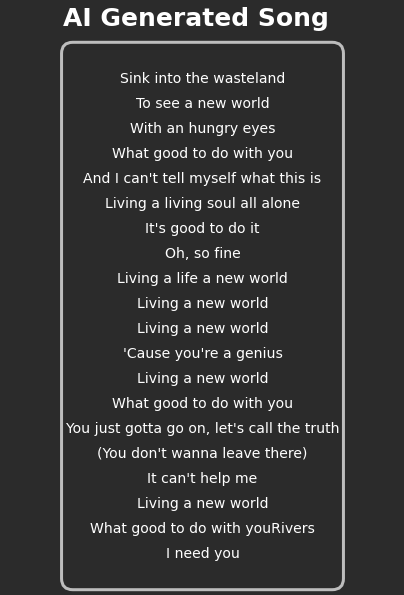

In [ ]:
imgd_prompt2 = "Sink into the wasteland"
imgd_gen_song2 = song_writer(imgd_prompt2, 200, imgd_model)
displaySong(imgd_gen_song2)

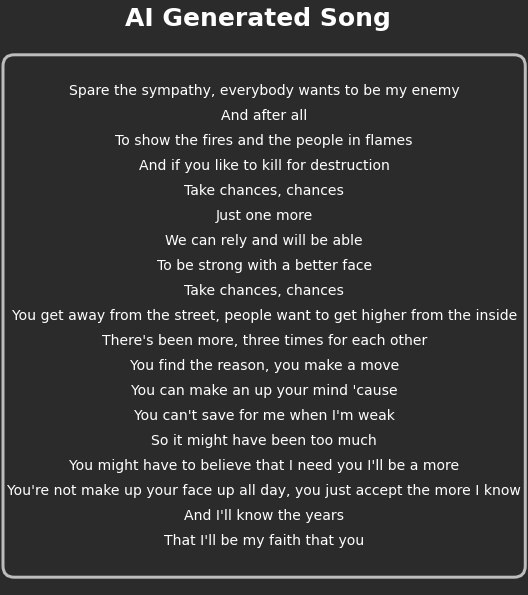

In [ ]:
imgd_prompt3 = "Spare the sympathy, everybody wants to be my enemy"
imgd_gen_song3 = song_writer(imgd_prompt3, 180, imgd_model)
displaySong(imgd_gen_song3)

## **Songs generated by: Neil Diamond Model**

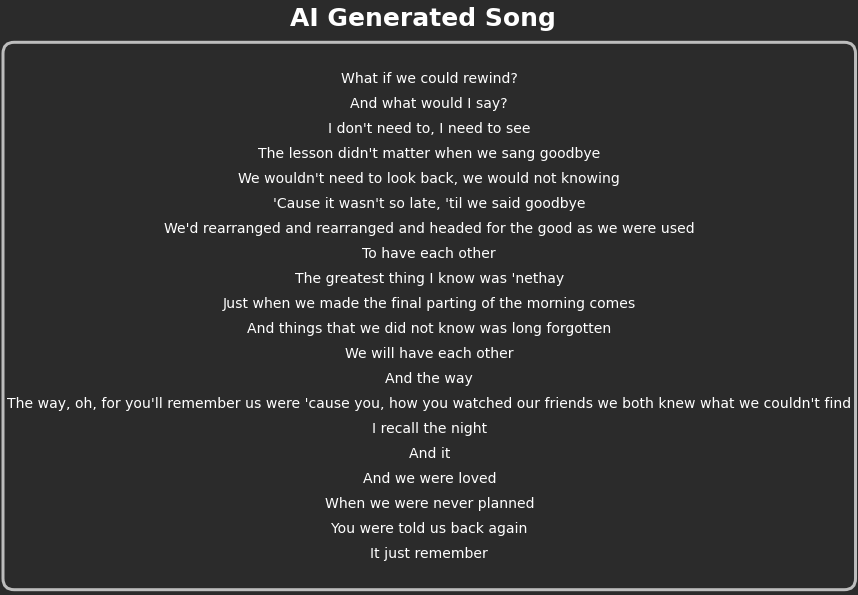

In [ ]:
neild_prompt1 = "What if we could rewind?"
neild_gen_song1 = song_writer(neild_prompt1, 200, neild_model)
displaySong(neild_gen_song1)

In [ ]:
neild_prompt2 = "She got the moves"
neild_gen_song2 = song_writer(neild_prompt2, 200, neild_model)
displaySong(neild_gen_song2)

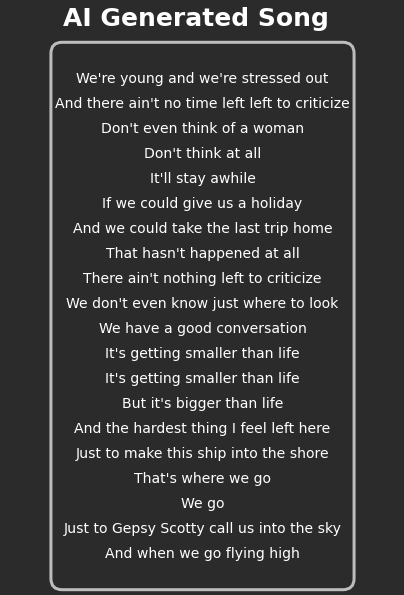

In [ ]:
neild_prompt3 = "We're young"
neild_gen_song3 = song_writer(neild_prompt3, 200, neild_model)
displaySong(neild_gen_song3)

## **Songs generated by: Rolling Stones Model**

In [ ]:
rolst_prompt1 = "You made me believe you're mine"
rolst_gen_song1 = song_writer(rolst_prompt1, 200, rolst_model)
displaySong(rolst_gen_song1)

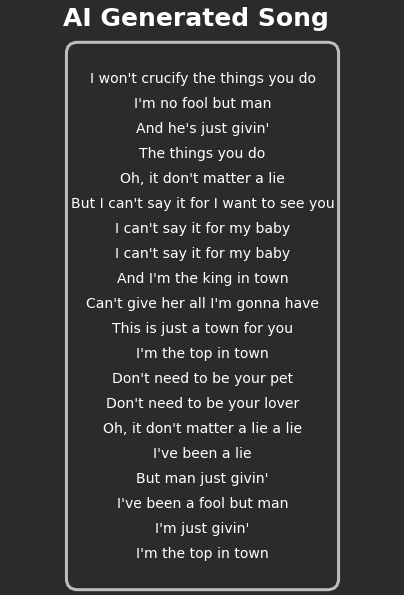

In [ ]:
rolst_prompt2 = "I won't crucify the things you do"
rolst_gen_song2 = song_writer(rolst_prompt2, 200, rolst_model)
displaySong(rolst_gen_song2)

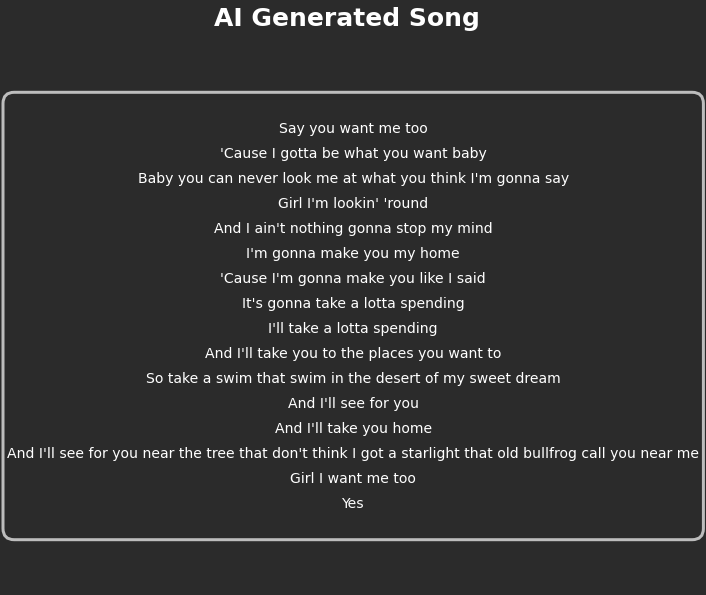

In [ ]:
rolst_prompt3 = "Say you want me"
rolst_gen_song3 = song_writer(rolst_prompt3, 160, rolst_model)
displaySong(rolst_gen_song3)

## **Songs generated by: The Beatles Model**

In [ ]:
tbeat_prompt1 = "Here comes the sun"
tbeat_gen_song1 = song_writer(tbeat_prompt1, 180, tbeat_model)
displaySong(tbeat_gen_song1)

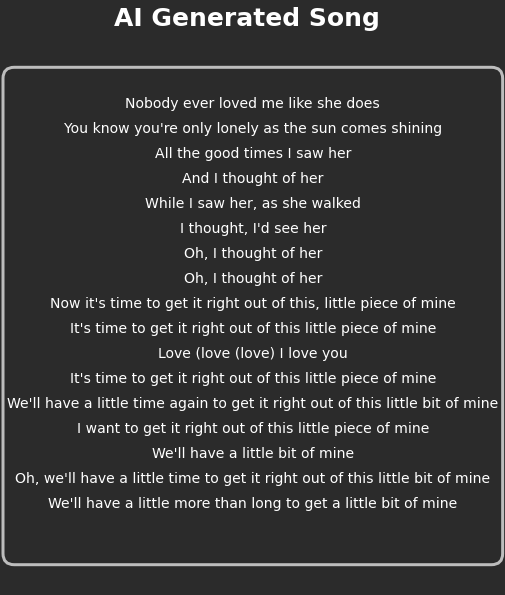

In [ ]:
tbeat_prompt2 = "Nobody ever loved me like she does"
tbeat_gen_song2 = song_writer(tbeat_prompt2, 200, tbeat_model)
displaySong(tbeat_gen_song2)

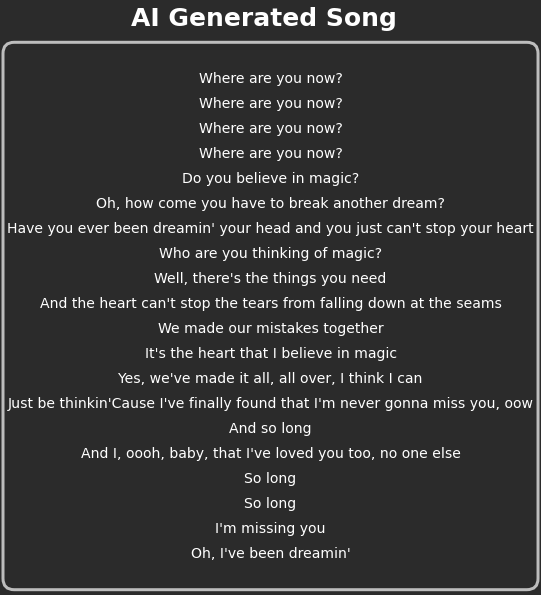

In [ ]:
tbeat_prompt3 = "Where are you now?"
tbeat_gen_song3 = song_writer(tbeat_prompt3, 220, tbeat_model)
displaySong(tbeat_gen_song3)

# **Writing Rap Songs**

## **Songs generated by: Rap Model**

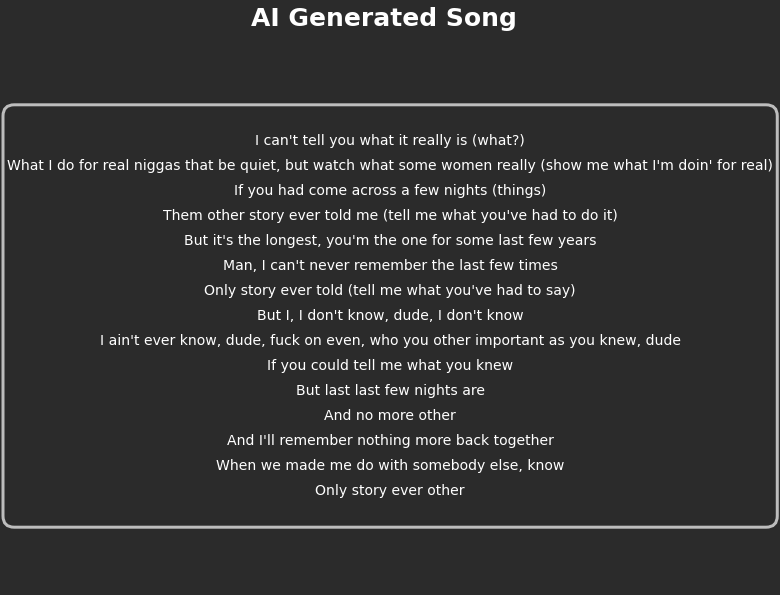

In [ ]:
rap_prompt1 = "I can't tell you what it really is"
rap_song1 = song_writer(rap_prompt1, 200, rap_model)
displaySong(rap_song1)

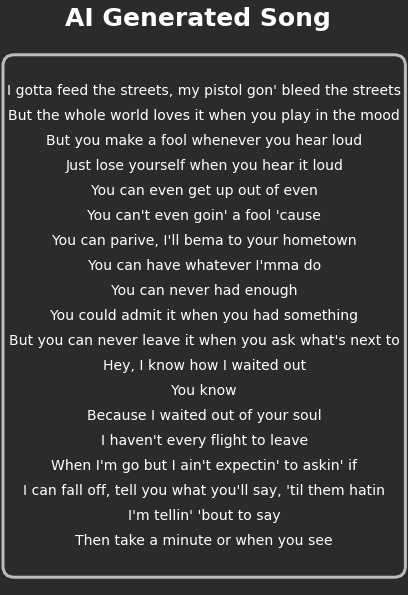

In [ ]:
rap_prompt2 = "I gotta feed the streets, my pistol gon' bleed the streets"
rap_song2 = song_writer(rap_prompt2, 200, rap_model)
displaySong(rap_song2)

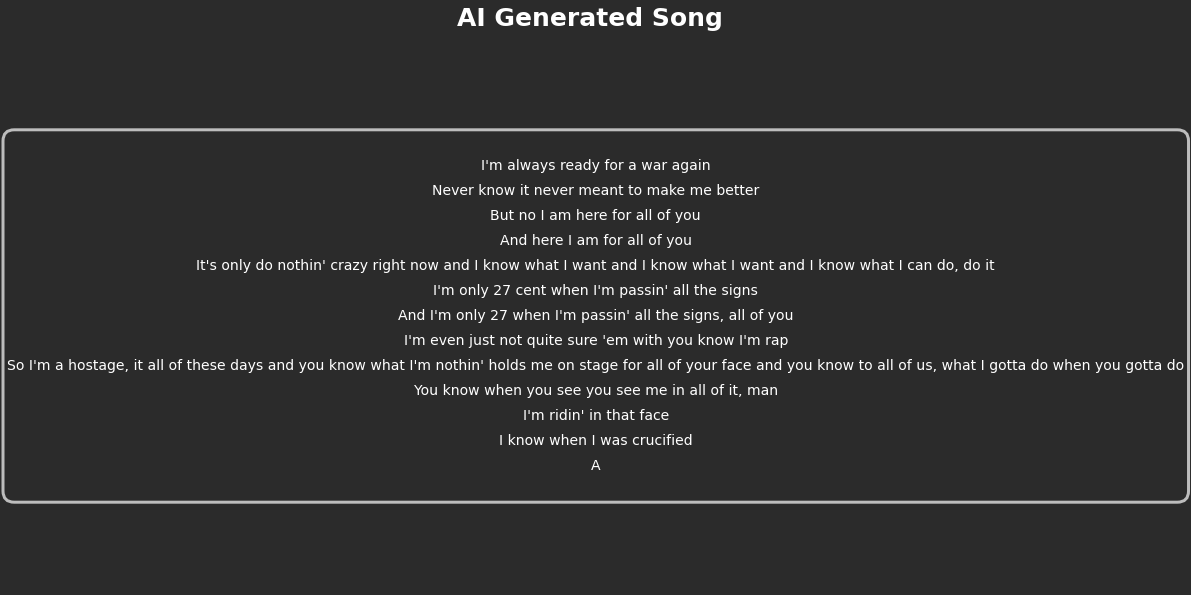

In [ ]:
rap_prompt3 = "I'm always ready for a war again"
rap_song3 = song_writer(rap_prompt3, 200, rap_model)
displaySong(rap_song3)

## **Songs generated by: Drake Model**

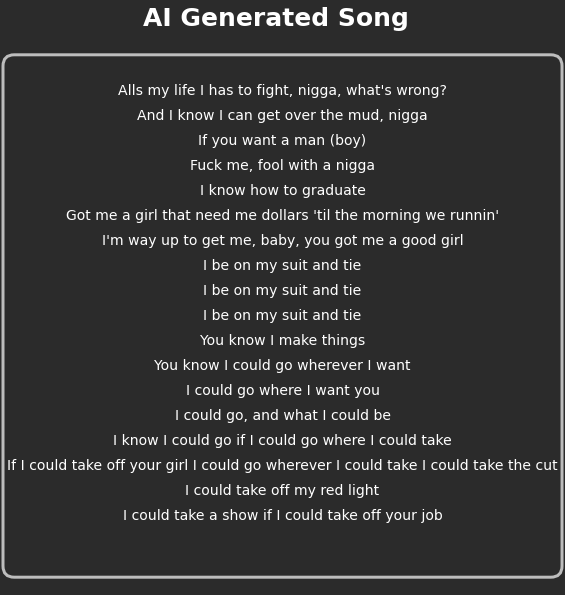

In [ ]:
drake_prompt1 = "Alls my life I has to fight, nigga"
drake_gen_song1 = song_writer(drake_prompt1, 200, drake_model)
displaySong(drake_gen_song1)

In [ ]:
drake_prompt2 = "Do you love me? Do you want me?"
drake_gen_song2 = song_writer(drake_prompt2, 200, drake_model)
displaySong(drake_gen_song2)

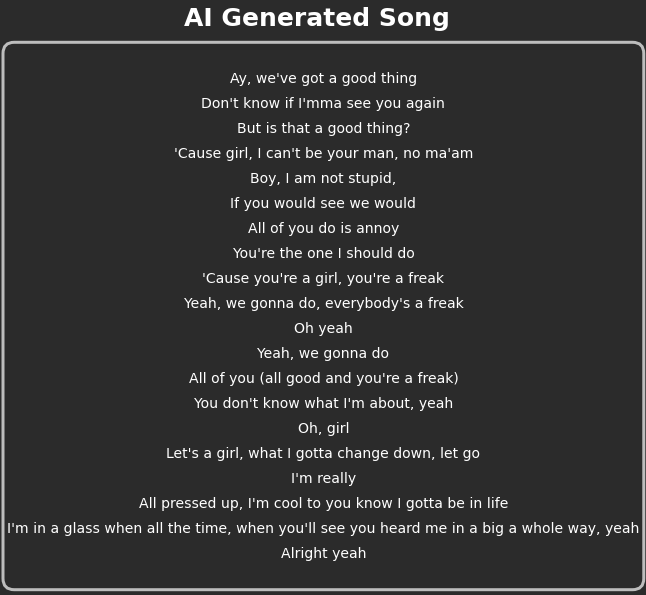

In [ ]:
drake_prompt3 = """Ay, we've got a good thing
Don't know if I'mma see you again
But is that a good thing?
'Cause girl, I can't be your man, no ma'am"""
drake_gen_song3 = song_writer(drake_prompt3, 200, drake_model)
displaySong(drake_gen_song3)

## **Songs generated by: Eminem Model**

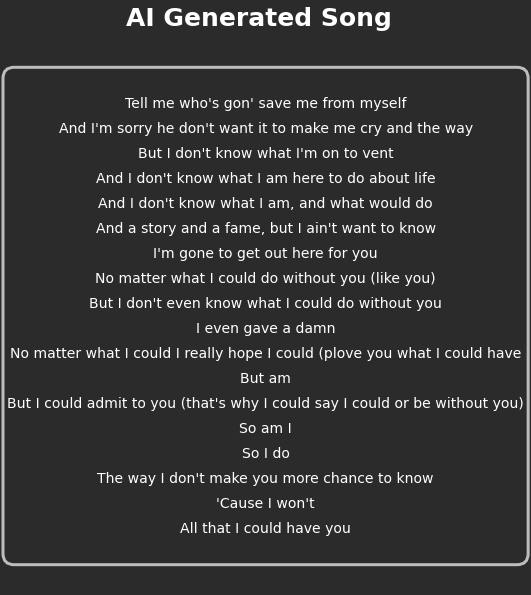

In [ ]:
eminem_prompt1 = "Tell me who's gon' save me from myself"
eminem_gen_song1 = song_writer(eminem_prompt1, 200, eminem_model)
displaySong(eminem_gen_song1)

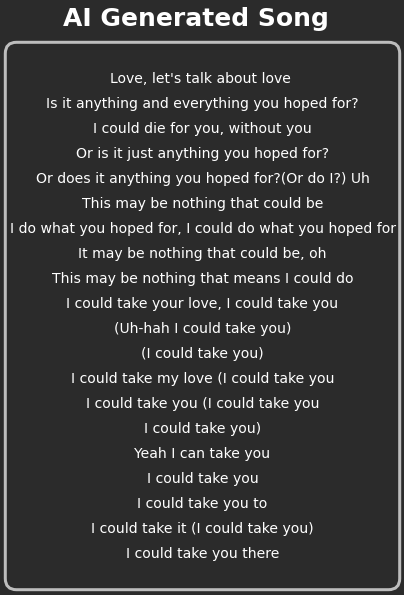

In [ ]:
eminem_prompt2 = "Love, let's talk about love \nIs it anything and everything you hoped for?"
eminem_gen_song2 = song_writer(eminem_prompt2, 200, eminem_model)
displaySong(eminem_gen_song2)

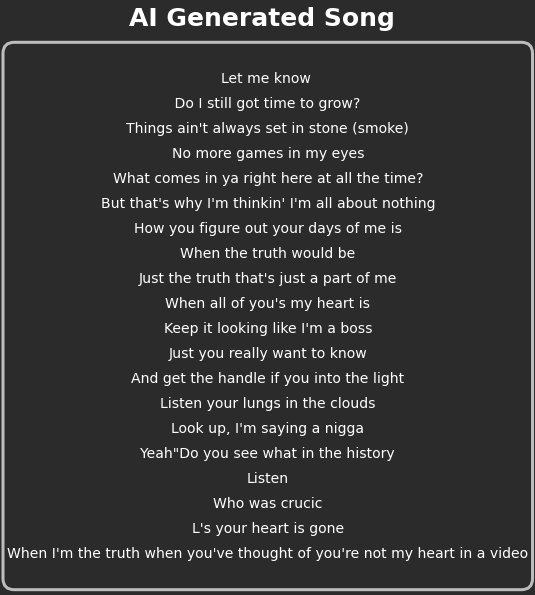

In [ ]:
eminem_prompt3 = "Let me know \n Do I still got time to grow? \nThings ain't always set in stone"
eminem_gen_song3 = song_writer(eminem_prompt3, 200, eminem_model)
displaySong(eminem_gen_song3)

## **Songs generated by: Kanye West Model**

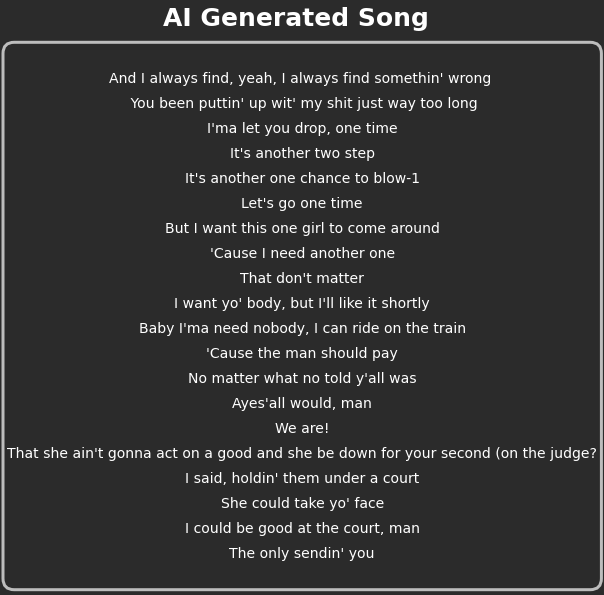

In [ ]:
kanye_prompt1 = "And I always find, yeah, I always find somethin' wrong \n You been puttin' up wit' my shit just way too long"
kanye_gen_song1 = song_writer(kanye_prompt1, 200, kanye_model)
displaySong(kanye_gen_song1)

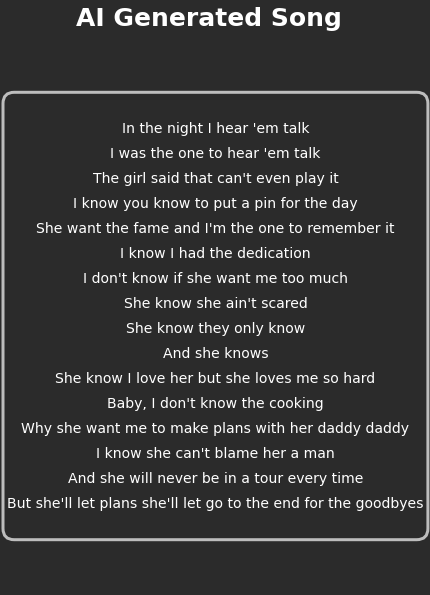

In [ ]:
kanye_prompt2 = "In the night I hear 'em talk"
kanye_gen_song2 = song_writer(kanye_prompt2, 160, kanye_model)
displaySong(kanye_gen_song2)

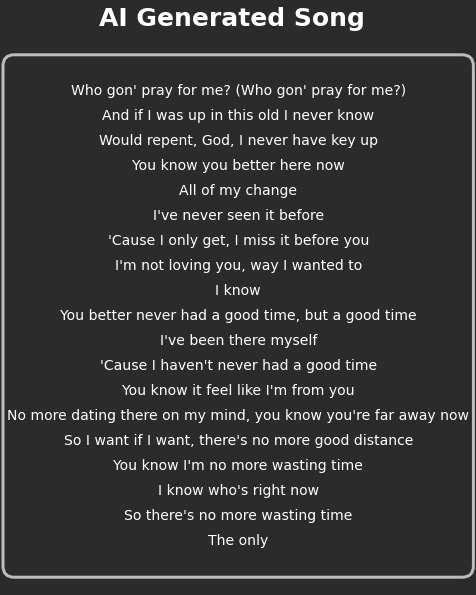

In [ ]:
kanye_prompt3 = "Who gon' pray for me? (Who gon' pray for me?)"
kanye_gen_song3 = song_writer(kanye_prompt3, 180, kanye_model)
displaySong(kanye_gen_song3)

## **Songs generated by: Lil Wayne Model**

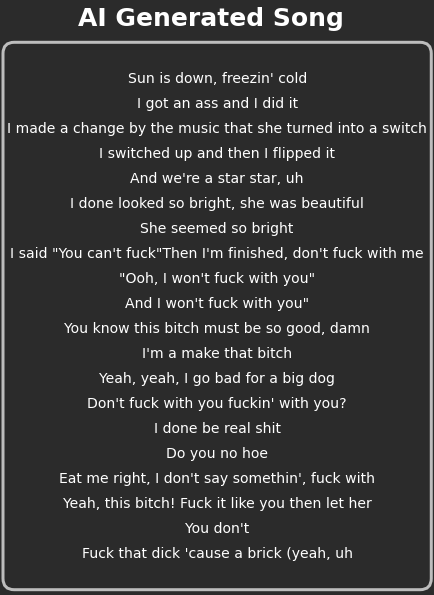

In [ ]:
wayne_prompt1 = "Sun is down, freezin' cold"
wayne_gen_song1 = song_writer(wayne_prompt1, 200, wayne_model)
displaySong(wayne_gen_song1)

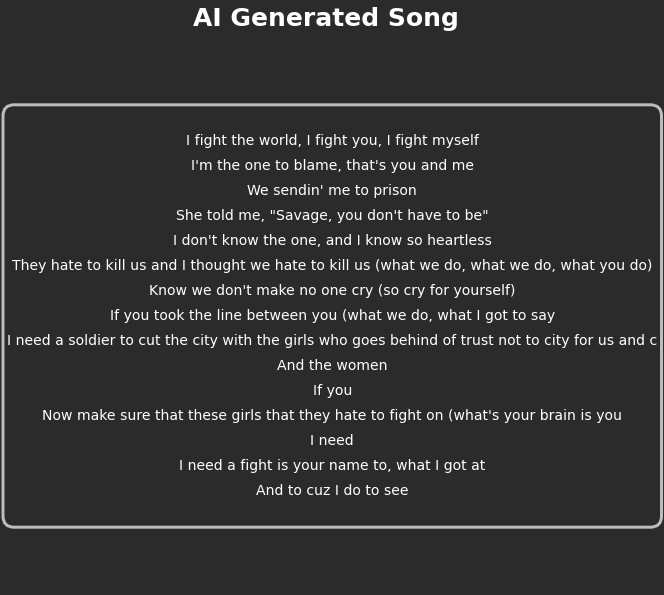

In [ ]:
wayne_prompt2 = "I fight the world, I fight you, I fight myself"
wayne_gen_song2 = song_writer(wayne_prompt2, 200, wayne_model)
displaySong(wayne_gen_song2)

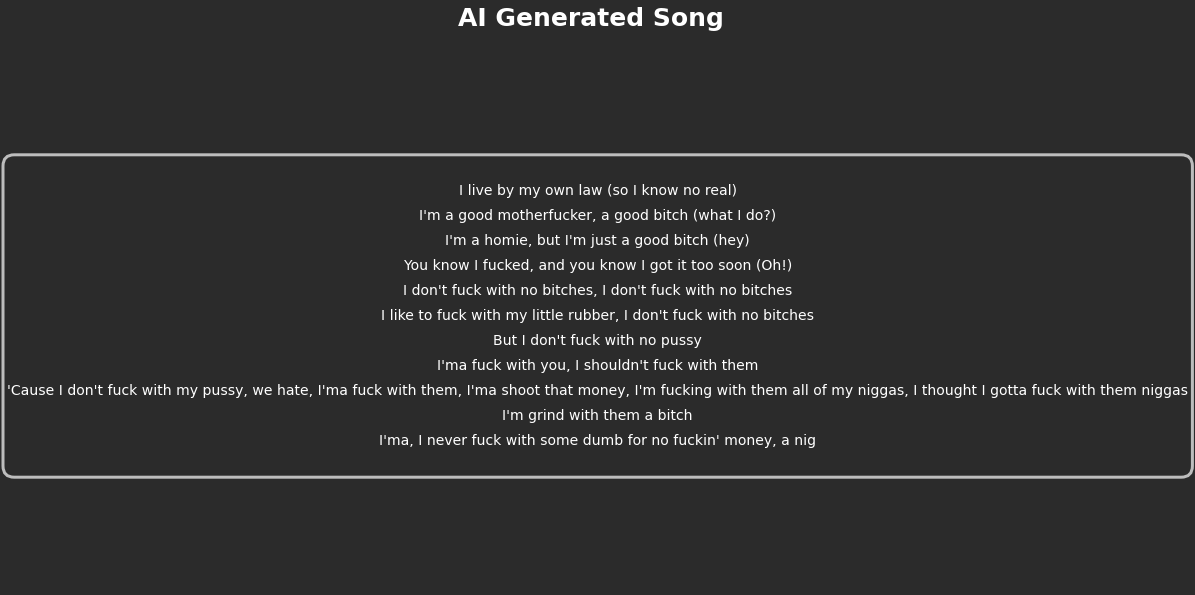

In [ ]:
wayne_prompt3 = "I live by my own law"
wayne_gen_song3 = song_writer(wayne_prompt3, 200, wayne_model)
displaySong(wayne_gen_song3)

## **Songs generated by: Nicki Minaj Model**

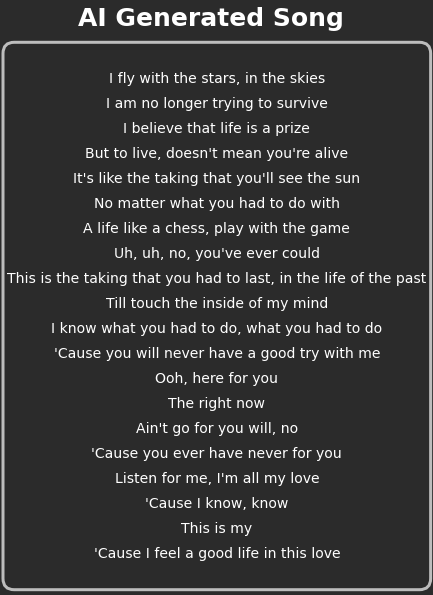

In [ ]:
nicki_prompt1 = """I fly with the stars, in the skies
I am no longer trying to survive
I believe that life is a prize
But to live, doesn't mean you're alive"""
nicki_gen_song1 = song_writer(nicki_prompt1, 200, nicki_model)
displaySong(nicki_gen_song1)

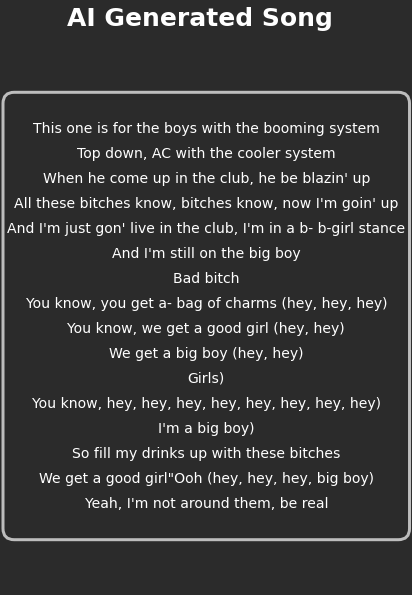

In [ ]:
nicki_prompt2 = """This one is for the boys with the booming system
Top down, AC with the cooler system
When he come up in the club, he be blazin' up
"""
nicki_gen_song2 = song_writer(nicki_prompt2, 200, nicki_model)
displaySong(nicki_gen_song2)

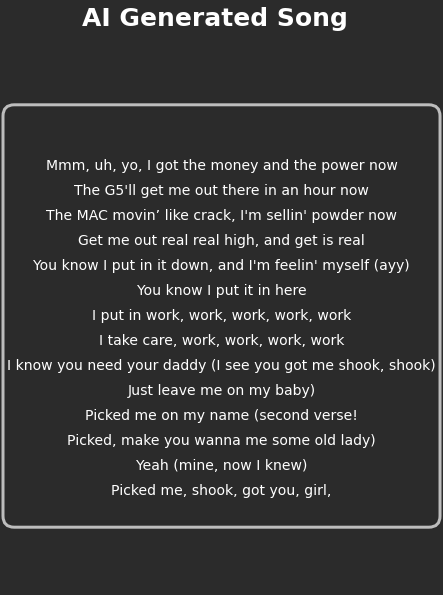

In [ ]:
nicki_prompt3 = """
Mmm, uh, yo, I got the money and the power now
The G5'll get me out there in an hour now
The MAC movin’ like crack, I'm sellin' powder now
"""
nicki_gen_song3 = song_writer(nicki_prompt3, 180, nicki_model)
displaySong(nicki_gen_song3)

# **Writing Songs: Mix & Match Genres/Artists**

Previously, we generated lyrics by using the fine-tune artist models trained using their respective genre models. This time, we'll play around with different combinations of artists and genres.

### **Mariah Carey as a Rap Artist**

Song generation by fine-tuning the rap model using Mariah Carey's artist dataset.

In [ ]:
mcrap_train, mcrap_val, mcrap_model = finetune_model(rap_model, mariahcarey_lmds, learning_rate = 1e-5)
history_mcrap = mcrap_model.fit(mcrap_train, validation_data = mcrap_val, epochs = 5)

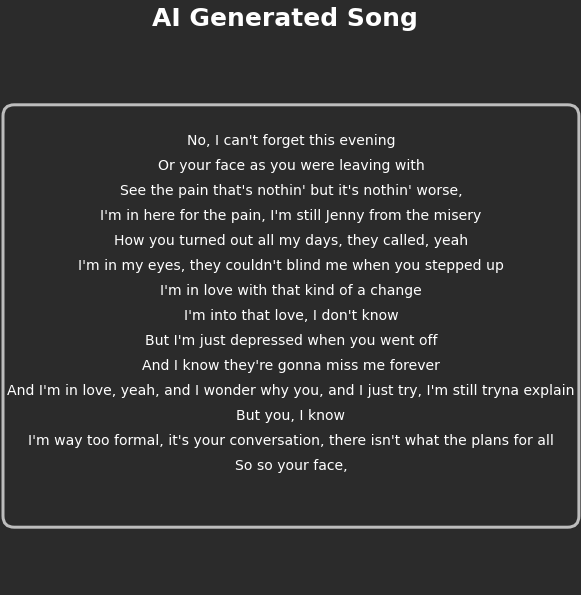

In [ ]:
prompt = """No, I can't forget this evening
Or your face as you were leaving"""
gensong = song_writer(prompt, 180, mcrap_model)
displaySong(gensong)

###**Eminem as a Pop Artist**

Song generation by fine-tuning the pop model using Eminem's artist dataset.

In [ ]:
emipop_train, emipop_val, emipop_model = finetune_model(pop_model, eminem_lmds, learning_rate = 1e-5)
history_emipop = emipop_model.fit(emipop_train, validation_data = emipop_val, epochs = 5)

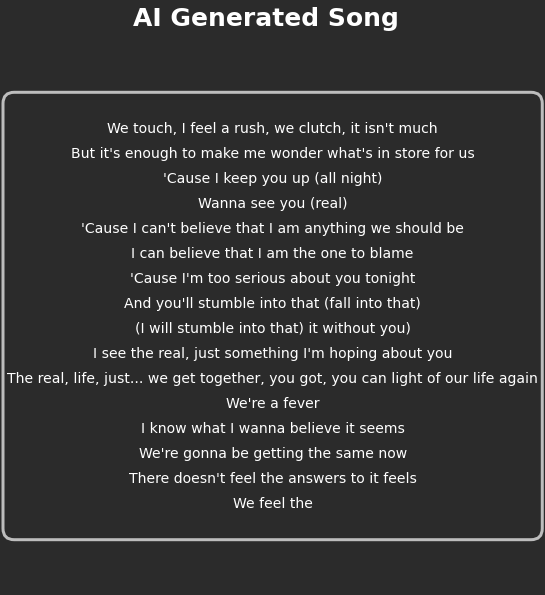

In [ ]:
prompt = """We touch, I feel a rush, we clutch, it isn't much
But it's enough to make me wonder what's in store for us"""
gensong = song_writer(prompt, 180, emipop_model)
displaySong(gensong)

###**Nicki Minaj as a Rock Artist**

Song generation by fine-tuning the rock model using Nicki Minaj's artist dataset.

In [ ]:
nmrock_train, nmrock_val, nmrock_model = finetune_model(rock_model, nicki_lmds, learning_rate = 1e-4)
history_nmrock = nmrock_model.fit(nmrock_train, validation_data = nmrock_val, epochs = 5)

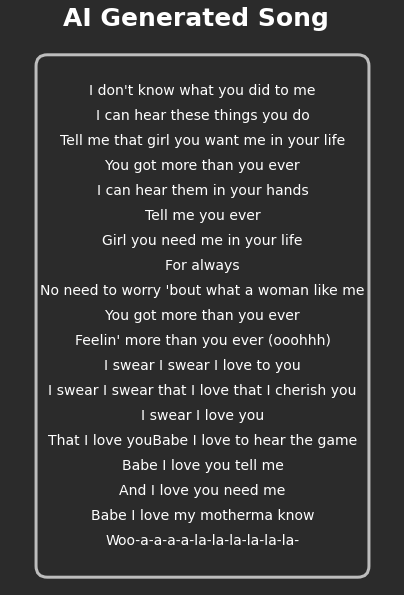

In [ ]:
prompt = "I don't know what you did to me"
gensong = song_writer(prompt, 180, nmrock_model)
displaySong(gensong)

###**Madonna as a Rock Artist**

Song generation by fine-tuning the rock model using Madonna's artist dataset.

In [ ]:
madorock_train, madorock_val, madorock_model = finetune_model(rock_model, madonna_lmds, learning_rate = 1e-4)
history_madorock = madorock_model.fit(madorock_train, validation_data = madorock_val, epochs = 5)

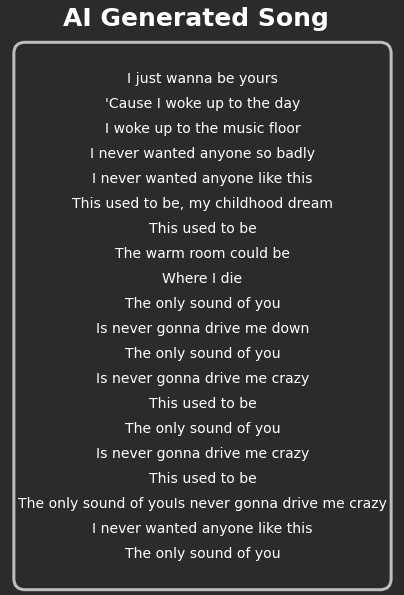

In [ ]:
prompt = "I just wanna be yours"
gensong = song_writer(prompt, 180, madorock_model)
displaySong(gensong)

###**Rihanna & Eminem mashup**

Song generation by fine-tuning the Eminem model using Rihanna's artist dataset.

In [ ]:
rihem_train, rihem_val, rihem_model = finetune_model(eminem_model, rihanna_lmds, learning_rate = 1e-4)
history_rihem = rihem_model.fit(rihem_train, validation_data = rihem_val, epochs = 5)

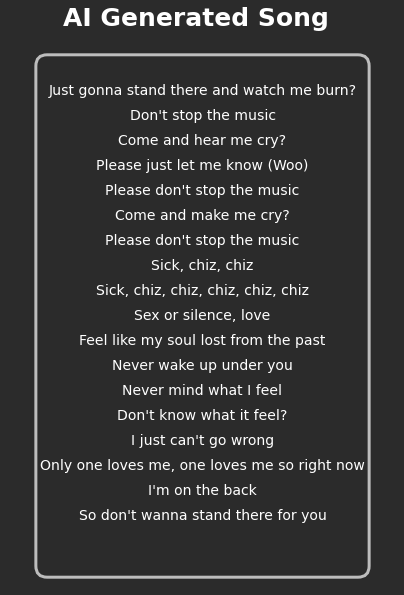

In [ ]:
prompt = "Just gonna stand there and watch me burn?"
gensong = song_writer(prompt, 150, rihem_model)
displaySong(gensong)

###**Taylor Swift & Neil Diamond mashup**

Song generation by fine-tuning the Neil Diamond model using Taylor Swift's artist dataset.

In [ ]:
tayneil_train, tayneil_val, tayneil_model = finetune_model(neild_model, taylorswift_lmds, learning_rate = 1e-4)
history_tayneil = tayneil_model.fit(tayneil_train, validation_data = tayneil_val, epochs = 5)

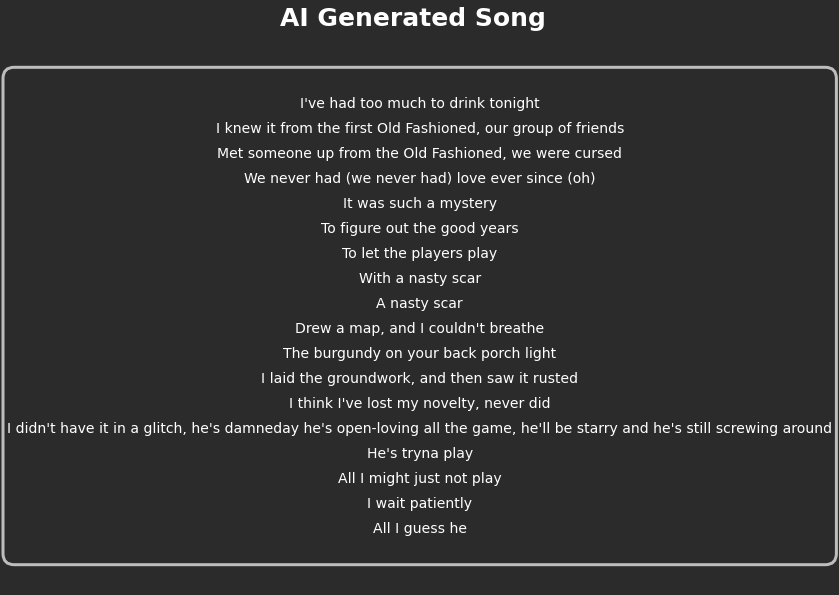

In [ ]:
prompt = "I've had too much to drink tonight"
gensong = song_writer(prompt, 180, tayneil_model)
displaySong(gensong)

#**Conclusion & Futurework**

Taking into account the limitation of our resources, the results produced by GPT2 Model were somewhat satisfactory. Regardless, lyrical generation by these models can be improved. This is because GPT2 is trained on a
large corpora of prose text which is very
different to the lyrical text in terms of
structure. One cannot observe line length, word variation & repetition,
rhyming density cannot in a prose text. <br>
Better results can be achieved by training State of the Art Language Models from
scratch using a large corpora of lyrical
text (song lyrics, poems etc.) instead of
using models pre-trained on prose text. <br>
Another strategy could be to experiment with a bigger chunk size. Due to RAM limitations, we restricted ourselves to sequences of length $128$, but theoretically a bigger sequence length like $512$ could be more suited to the task at hand.